Loading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
warnings.simplefilter('ignore')
matplotlib.rcParams['figure.dpi'] = 100
sns.set()
%matplotlib inline

In [2]:
# cargo la data

building = pd.read_csv('../Data/ashrae-energy-prediction/building_metadata.csv')
weather_train = pd.read_csv('../Data/ashrae-energy-prediction/weather_train.csv')
weather_test = pd.read_csv('../Data/ashrae-energy-prediction/weather_test.csv')
train = pd.read_csv('../Data/ashrae-energy-prediction/train.csv')
test = pd.read_csv('../Data/ashrae-energy-prediction/test.csv')

Merging everything into two datasets: train and test

In [3]:
# genero un dataset con toda la data (train/test)

train = train.merge(building, on='building_id', how='left')
test = test.merge(building, on='building_id', how='left')

train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')
del weather_train, weather_test,building
gc.collect();

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   building_id         int64  
 1   meter               int64  
 2   timestamp           object 
 3   meter_reading       float64
 4   site_id             int64  
 5   primary_use         object 
 6   square_feet         int64  
 7   year_built          float64
 8   floor_count         float64
 9   air_temperature     float64
 10  cloud_coverage      float64
 11  dew_temperature     float64
 12  precip_depth_1_hr   float64
 13  sea_level_pressure  float64
 14  wind_direction      float64
 15  wind_speed          float64
dtypes: float64(10), int64(4), object(2)
memory usage: 2.6+ GB


In [124]:
train.wind_direction.value_counts()

0.0      478207
300.0    166386
270.0    163621
290.0    160328
280.0    152385
170.0    143276
260.0    142473
310.0    132554
180.0    131908
190.0    128241
320.0    119851
160.0    116727
200.0    113003
250.0    108423
330.0    106905
210.0    105530
340.0    101049
70.0     100379
150.0     97467
230.0     96298
350.0     96055
80.0      94613
240.0     93992
60.0      92977
100.0     91873
220.0     91297
90.0      90344
140.0     90150
360.0     85778
110.0     84996
130.0     84761
120.0     84373
50.0      79761
30.0      70172
20.0      70148
40.0      69638
10.0      65946
202.0        26
198.0        16
84.0         16
174.0        16
176.0        16
196.0        16
Name: wind_direction, dtype: int64

In [5]:
train.primary_use.value_counts()

Education                        8165504
Office                           4394864
Entertainment/public assembly    2264917
Lodging/residential              2146413
Public services                  1662826
Healthcare                        398527
Other                             242222
Parking                           213796
Manufacturing/industrial          125713
Food sales and service            114090
Retail                            112657
Warehouse/storage                 111861
Services                           96519
Technology/science                 77627
Utility                            56203
Religious worship                  32361
Name: primary_use, dtype: int64

In [6]:
train.shape

(20216100, 16)

In [7]:
# vamos a trabajar solo con los medidores de electricidad (meter == 0)

# dataset para train
mask_meter_train = train.meter == 0
train_m0 = train.loc[mask_meter_train]


# dataset para el test
mask_meter_test = test.meter == 0
test_m0 = test.loc[mask_meter_test]

In [8]:
# comparo tamaño de los datasets pre y post filtrado
print('Tamaño del train antes del filtro:',train.shape[0])
print('Tamaño del train depués del filtro:',train_m0.shape[0])
print('Tamaño del test antes del filtro:',test.shape[0])
print('Tamaño del test después del filtro:',test_m0.shape[0])

Tamaño del train antes del filtro: 20216100
Tamaño del train depués del filtro: 12060910
Tamaño del test antes del filtro: 41697600
Tamaño del test después del filtro: 24755760


In [9]:
# vamos a trabajar solo con establecimientos educativos (prymary_use == 'Education')

# dataset para train
mask_mprimary_use_train = train_m0.primary_use == 'Education'
train_m0_primary_use = train_m0.loc[mask_mprimary_use_train]


# dataset para el test
mask_mprimary_use_test = test_m0.primary_use == 'Education'
test_m0_primary_use = test_m0.loc[mask_mprimary_use_test]

In [10]:
# comparo tamaño de los datasets pre y post filtrado
print('Tamaño del train antes del filtro:',train_m0.shape[0])
print('Tamaño del train depués del filtro:',train_m0_primary_use.shape[0])
print('Tamaño del test antes del filtro:',test_m0.shape[0])
print('Tamaño del test después del filtro:',test_m0_primary_use.shape[0])

Tamaño del train antes del filtro: 12060910
Tamaño del train depués del filtro: 4597256
Tamaño del test antes del filtro: 24755760
Tamaño del test después del filtro: 9408240


In [11]:
# asigno datasets

train = train_m0_primary_use
test = test_m0_primary_use

In [12]:
# agregar reporte de ahorro de memoria!!!

# Saving some memory
d_types = {'building_id': np.int16,
          'meter': np.int8,
          'site_id': np.int8,
          'primary_use': 'category',
          'square_feet': np.int32,
          'year_built': np.float16,
          'floor_count': np.float16,
          'air_temperature': np.float32,
          'cloud_coverage': np.float16,
          'dew_temperature': np.float32,
          'precip_depth_1_hr': np.float16,
          'sea_level_pressure': np.float32,
          'wind_direction': np.float16,
          'wind_speed': np.float32}

for feature in d_types:
    train[feature] = train[feature].astype(d_types[feature])
    test[feature] = test[feature].astype(d_types[feature])
    
train["timestamp"] = pd.to_datetime(train["timestamp"])
test["timestamp"] = pd.to_datetime(test["timestamp"])
gc.collect();

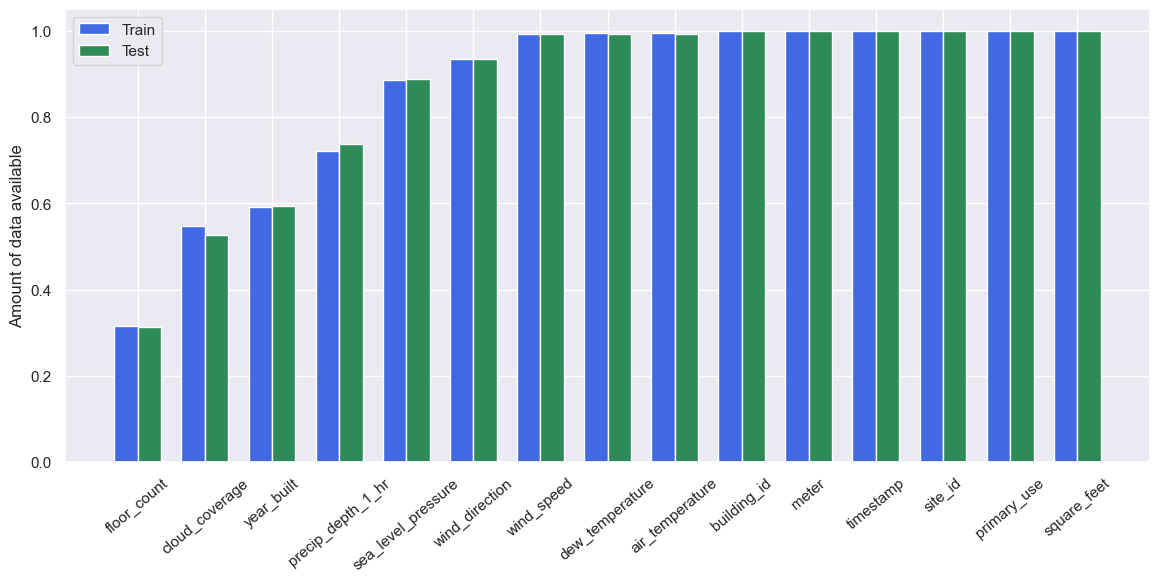

In [13]:
train_data = (train.count() / len(train)).drop('meter_reading').sort_values().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = (test.count() / len(test)).drop('row_id').sort_values().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Amount of data available');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels((train.count() / len(train)).drop('meter_reading').sort_values().index, rotation=40)
axes.legend([tr, tt], ['Train', 'Test']);

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4597256 entries, 0 to 20216096
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int16         
 1   meter               int8          
 2   timestamp           datetime64[ns]
 3   meter_reading       float64       
 4   site_id             int8          
 5   primary_use         category      
 6   square_feet         int32         
 7   year_built          float16       
 8   floor_count         float16       
 9   air_temperature     float32       
 10  cloud_coverage      float16       
 11  dew_temperature     float32       
 12  precip_depth_1_hr   float16       
 13  sea_level_pressure  float32       
 14  wind_direction      float16       
 15  wind_speed          float32       
dtypes: category(1), datetime64[ns](1), float16(5), float32(4), float64(1), int16(1), int32(1), int8(2)
memory usage: 258.7 MB


In [31]:
train.site_id.value_counts().sort_values()

11     43400
7     104784
10    109519
6     113899
12    175669
1     193248
13    201898
14    227347
0     258480
15    305382
5     430416
2     535446
9     552209
4     557399
3     788160
Name: site_id, dtype: int64

In [30]:
aa = train.site_id == 6
aa.sum()

113899

In [17]:
train.head()

building_id  meter  timestamp  meter_reading  site_id primary_use  \
0            0      0 2016-01-01            0.0        0   Education   
1            1      0 2016-01-01            0.0        0   Education   
2            2      0 2016-01-01            0.0        0   Education   
3            3      0 2016-01-01            0.0        0   Education   
4            4      0 2016-01-01            0.0        0   Education   

   square_feet  year_built  floor_count  air_temperature  cloud_coverage  \
0         7432      2008.0          NaN             25.0             6.0   
1         2720      2004.0          NaN             25.0             6.0   
2         5376      1991.0          NaN             25.0             6.0   
3        23685      2002.0          NaN             25.0             6.0   
4       116607      1975.0          NaN             25.0             6.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0                NaN         1019.700012             0.0   
1             20.0                NaN         1019.700012             0.0   
2             20.0                NaN         1019.700012             0.0   
3             20.0                NaN         1019.700012             0.0   
4             20.0                NaN         1019.700012             0.0   

   wind_speed  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

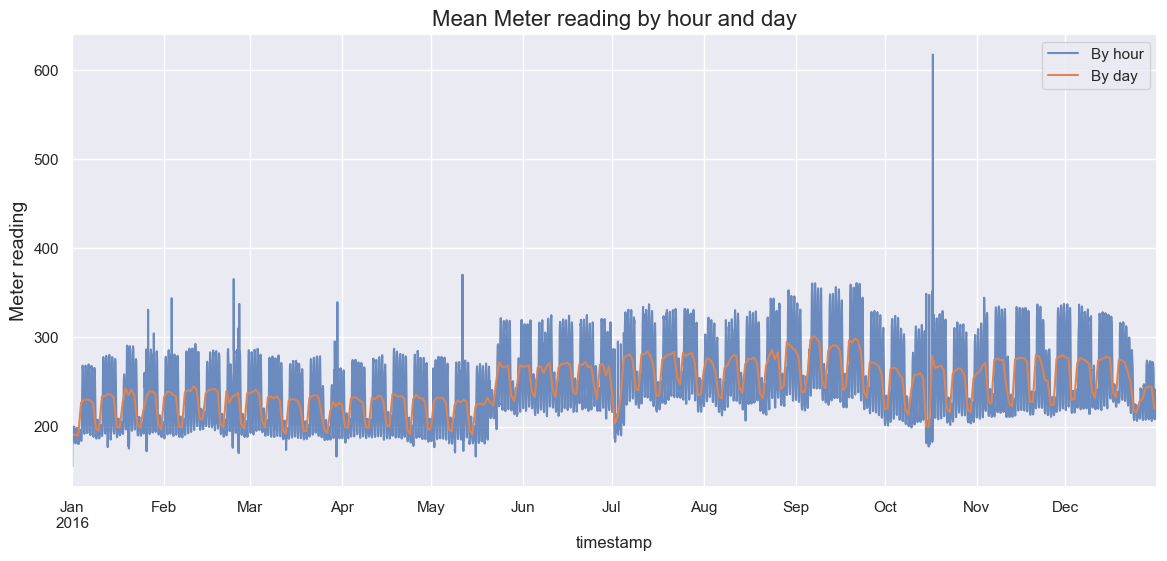

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi=100)
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14);
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='By day', alpha=1).set_ylabel('Meter reading', fontsize=14);
axes.set_title('Mean Meter reading by hour and day', fontsize=16);
axes.legend();

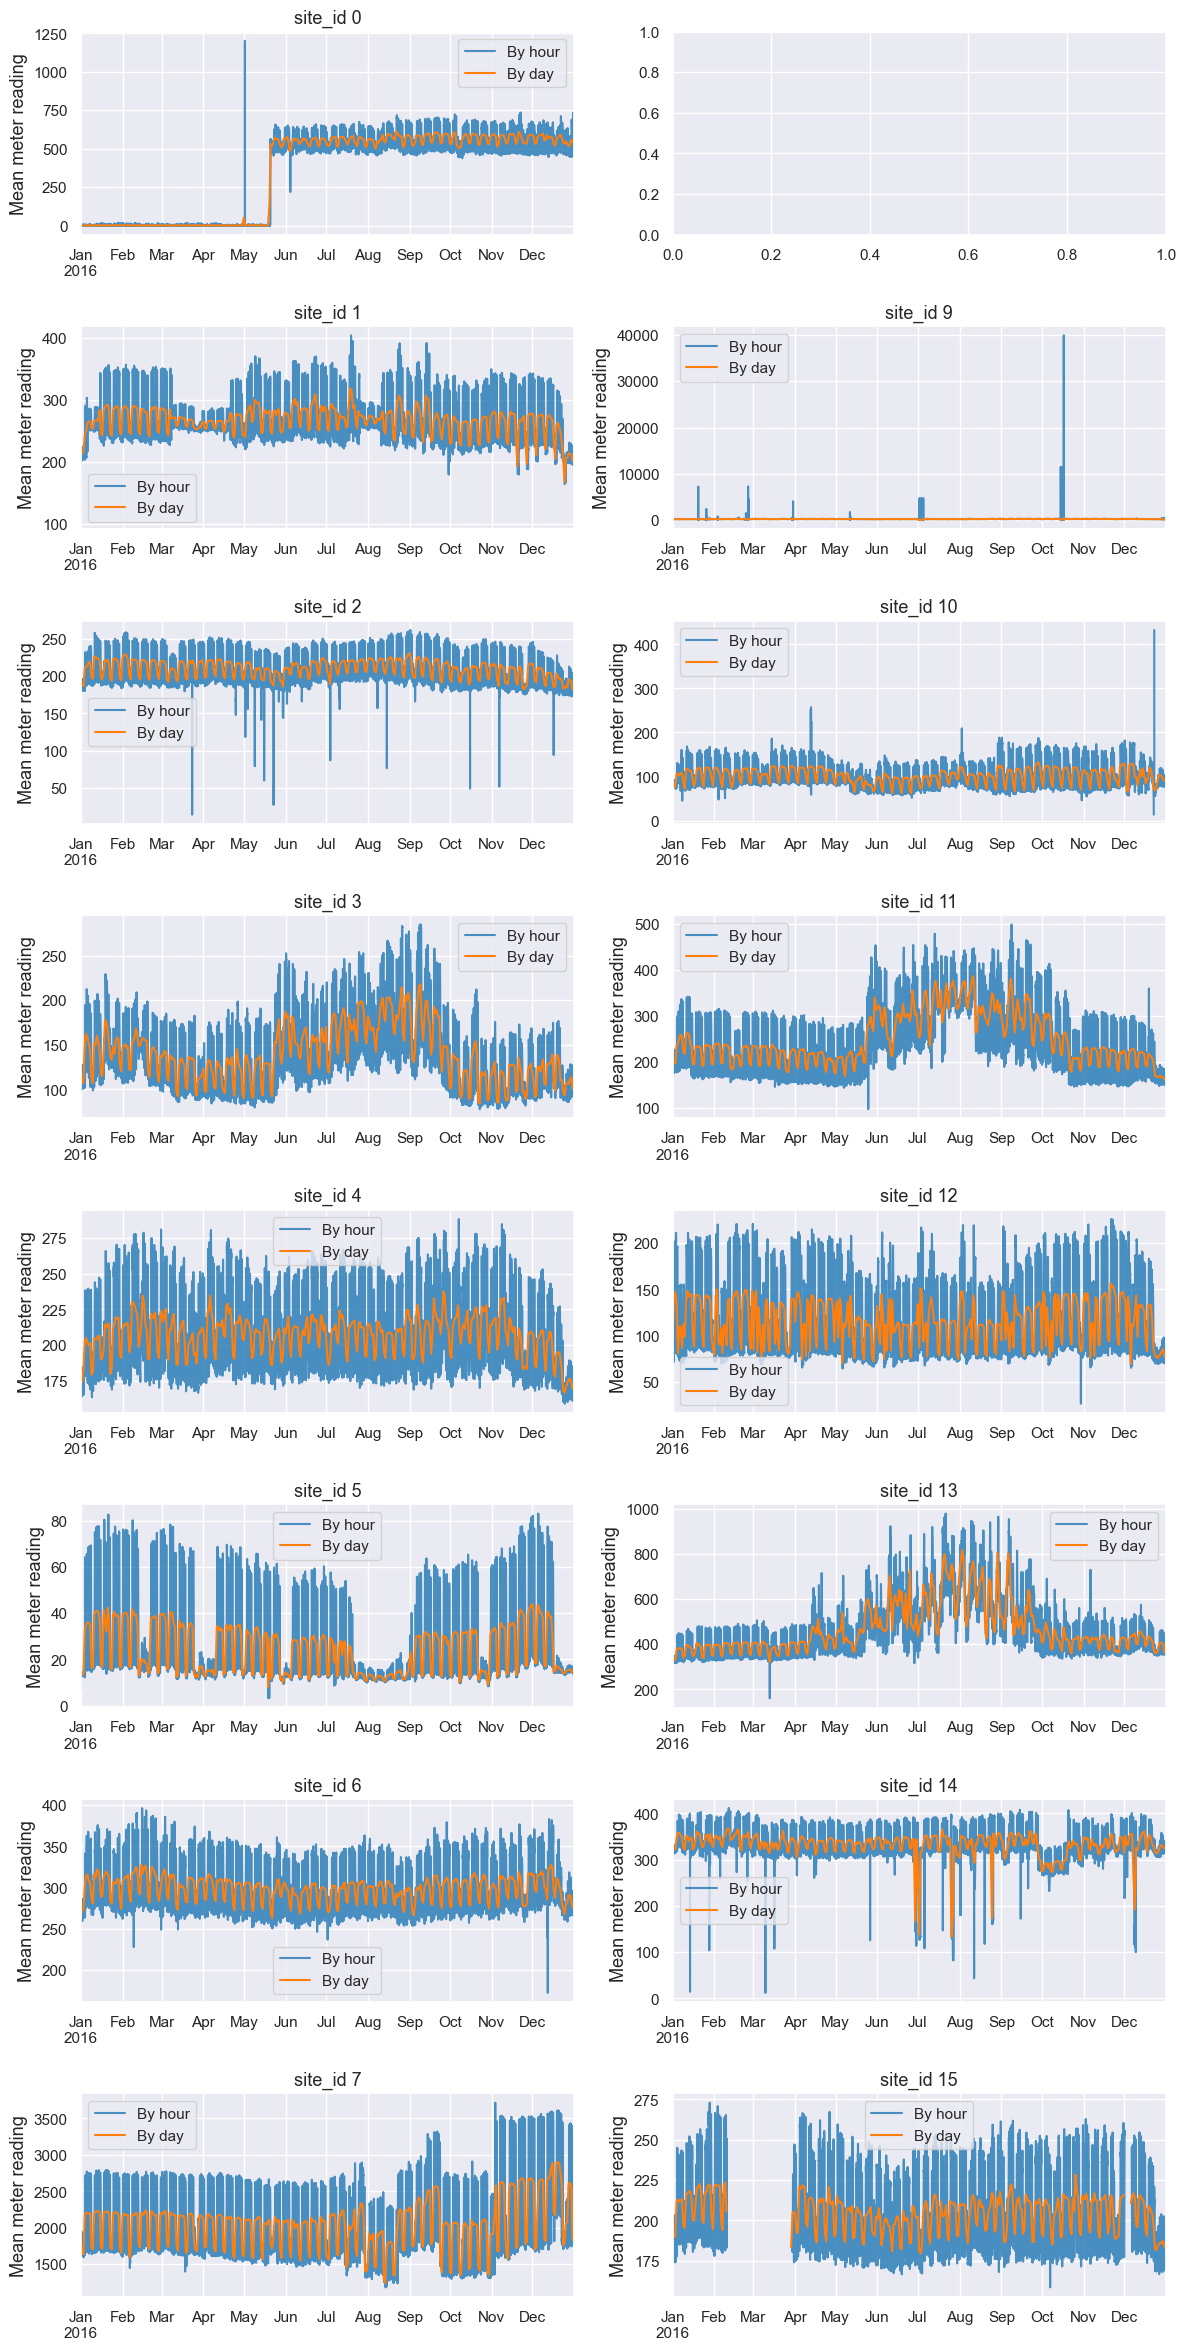

In [33]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i in range(16):
    if i == 8:
        continue
    train[train['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train[train['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    plt.subplots_adjust(hspace=0.45)

In [45]:
train.corr()

building_id  meter  meter_reading   site_id  square_feet  \
building_id            1.000000    NaN       0.040118  0.967755     0.133484   
meter                       NaN    NaN            NaN       NaN          NaN   
meter_reading          0.040118    NaN       1.000000  0.051788     0.608265   
site_id                0.967755    NaN       0.051788  1.000000     0.135579   
square_feet            0.133484    NaN       0.608265  0.135579     1.000000   
year_built            -0.178791    NaN       0.152320 -0.111295     0.201893   
floor_count           -0.267073    NaN       0.393200 -0.216153     0.639202   
air_temperature       -0.274562    NaN      -0.034177 -0.244501    -0.022079   
cloud_coverage        -0.153105    NaN      -0.021298 -0.105718    -0.015288   
dew_temperature       -0.086624    NaN      -0.027263 -0.107716    -0.031292   
precip_depth_1_hr      0.023974    NaN       0.023401  0.027539     0.011860   
sea_level_pressure     0.044256    NaN      -0.011646  0.019962    -0.006283   
wind_direction         0.023285    NaN       0.002434  0.006980    -0.008169   
wind_speed            -0.011105    NaN      -0.035218 -0.023002    -0.054360   

                    year_built  floor_count  air_temperature  cloud_coverage  \
building_id          -0.178791    -0.267073        -0.274562       -0.153105   
meter                      NaN          NaN              NaN             NaN   
meter_reading         0.152320     0.393200        -0.034177       -0.021298   
site_id              -0.111295    -0.216153        -0.244501       -0.105718   
square_feet           0.201893     0.639202        -0.022079       -0.015288   
year_built            1.000000     0.215312         0.119436       -0.002636   
floor_count           0.215312     1.000000         0.032572        0.102063   
air_temperature       0.119436     0.032572         1.000000        0.012294   
cloud_coverage       -0.002636     0.102063         0.012294        1.000000   
dew_temperature       0.068273    -0.003887         0.706214        0.133273   
precip_depth_1_hr     0.016632     0.049328        -0.015299        0.131311   
sea_level_pressure   -0.027416     0.000249        -0.302747       -0.130113   
wind_direction       -0.051248     0.023241        -0.067959        0.061648   
wind_speed           -0.043683    -0.086793        -0.076888        0.256035   

                    dew_temperature  precip_depth_1_hr  sea_level_pressure  \
building_id               -0.086624           0.023974            0.044256   
meter                           NaN                NaN                 NaN   
meter_reading             -0.027263           0.023401           -0.011646   
site_id                   -0.107716           0.027539            0.019962   
square_feet               -0.031292           0.011860           -0.006283   
year_built                 0.068273           0.016632           -0.027416   
floor_count               -0.003887           0.049328            0.000249   
air_temperature            0.706214          -0.015299           -0.302747   
cloud_coverage             0.133273           0.131311           -0.130113   
dew_temperature            1.000000           0.064115           -0.196749   
precip_depth_1_hr          0.064115           1.000000           -0.062291   
sea_level_pressure        -0.196749          -0.062291            1.000000   
wind_direction            -0.131008          -0.013038           -0.106344   
wind_speed                -0.110507           0.031367           -0.212967   

                    wind_direction  wind_speed  
building_id               0.023285   -0.011105  
meter                          NaN         NaN  
meter_reading             0.002434   -0.035218  
site_id                   0.006980   -0.023002  
square_feet              -0.008169   -0.054360  
year_built               -0.051248   -0.043683  
floor_count               0.023241   -0.086793  
air_temperature          -0.067959   -0.076888  
cloud_

**Meter**

meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, hotwater: 3}. Not every building has all meter type

Looks like steam is the most unefficient way of heating things up.

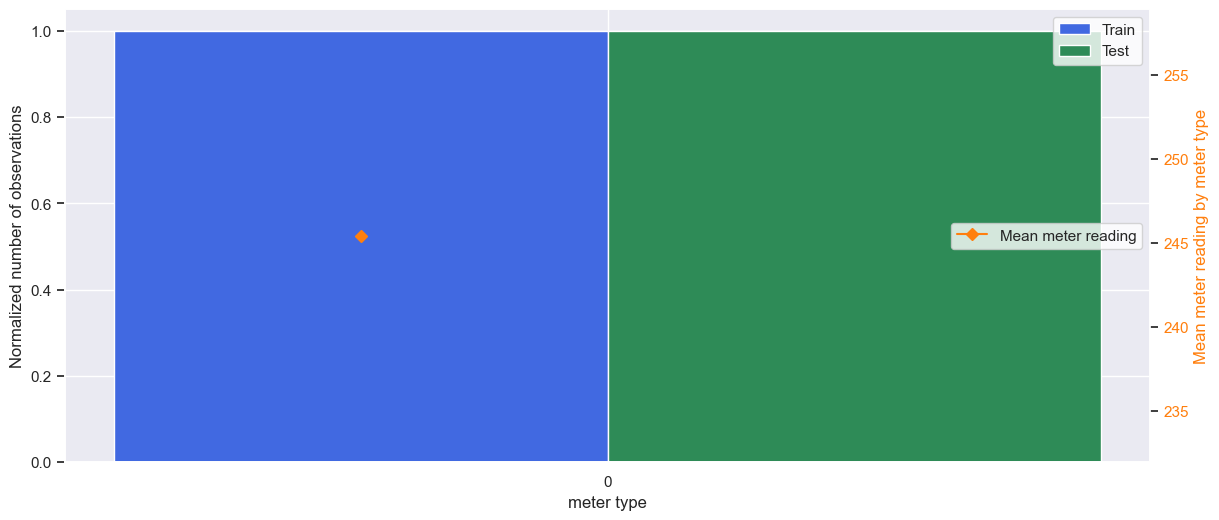

In [47]:
train_data = train['meter'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['meter'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('meter type');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['meter'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['meter', 'meter_reading']].groupby('meter')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by meter type', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=5, facecolor='white');

**Box plot of meter reading by meter type with outliers removed**

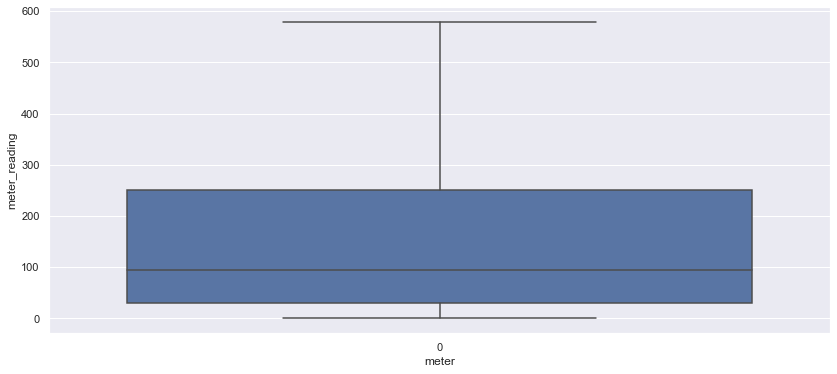

In [48]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='meter', y='meter_reading', data=train, showfliers=False);

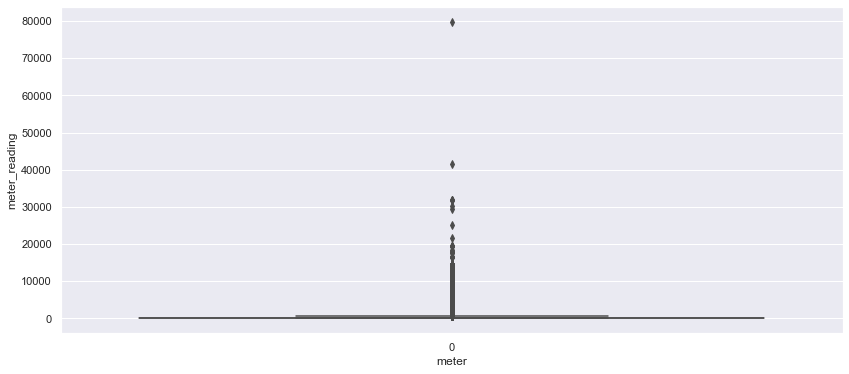

In [114]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='meter', y='meter_reading', data=train, showfliers=True);

**Box plot of air temperature by meter type**

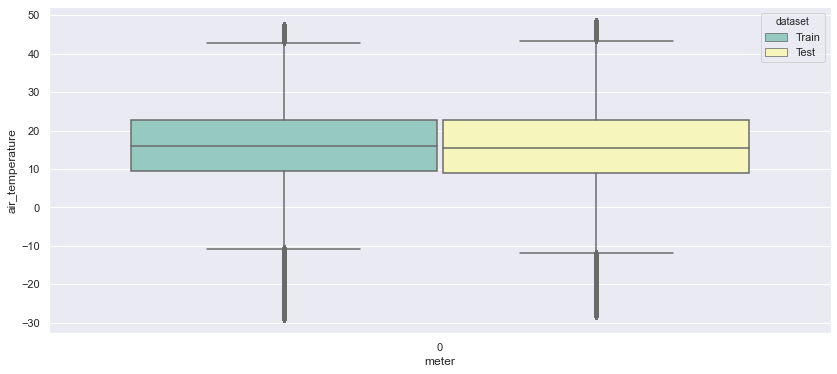

In [49]:
tmp_df = pd.concat([train[['meter', 'air_temperature']], test[['meter', 'air_temperature']]], ignore_index=True)
tmp_df['dataset'] = 'Train'
tmp_df.loc[tmp_df.index > len(train), 'dataset'] = 'Test'

fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='meter', y='air_temperature', data=tmp_df, hue='dataset', palette="Set3");

del tmp_df
gc.collect();

**site_id**

site_id - Foreign key for the weather files.

In my understanding this is a location.

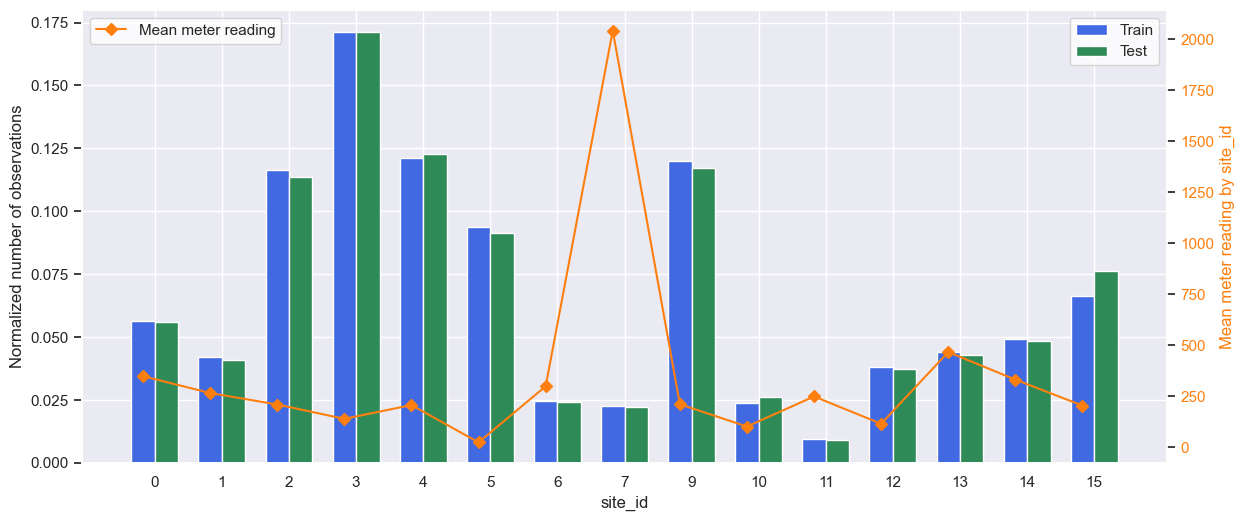

In [54]:
train_data = train['site_id'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['site_id'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('site_id');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['site_id'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['site_id', 'meter_reading']].groupby('site_id')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by site_id', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

**Box plot of meter reading by site_id with outliers removed**

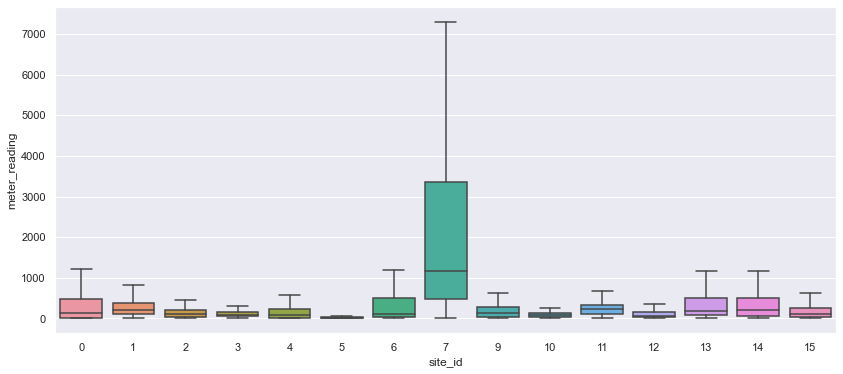

In [55]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='site_id', y='meter_reading', data=train, showfliers=False);

**Box plot of air temperature by site_id**

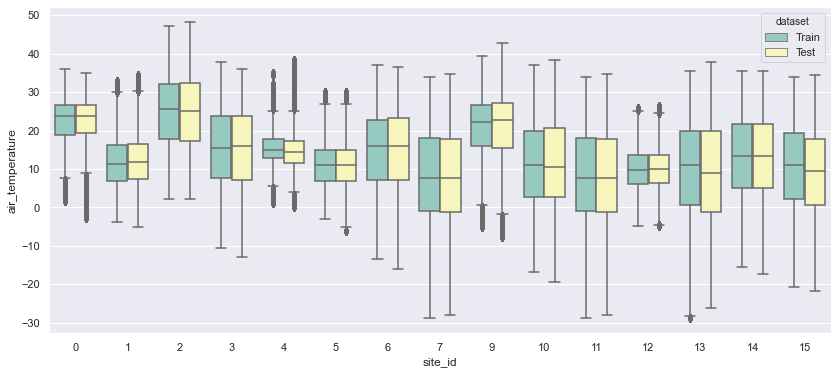

In [56]:
tmp_df = pd.concat([train[['site_id', 'air_temperature']], test[['site_id', 'air_temperature']]], ignore_index=True)
tmp_df['dataset'] = 'Train'
tmp_df.loc[tmp_df.index > len(train), 'dataset'] = 'Test'

fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='site_id', y='air_temperature', data=tmp_df, hue='dataset', palette="Set3");

del tmp_df
gc.collect();

**square_feet**

square_feet - Gross floor area of the building

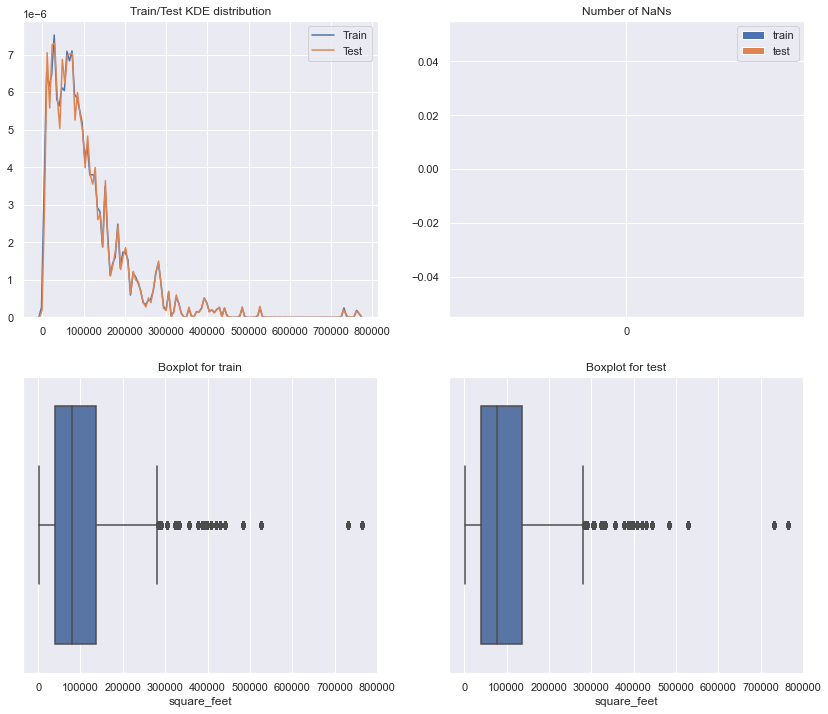

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
sns.kdeplot(train['square_feet'], ax=axes[0][0], label='Train');
sns.kdeplot(test['square_feet'], ax=axes[0][0], label='Test');
sns.boxplot(x=train['square_feet'], ax=axes[1][0]);
sns.boxplot(x=test['square_feet'], ax=axes[1][1]);
pd.DataFrame({'train': [train['square_feet'].isnull().sum()], 'test': [test['square_feet'].isnull().sum()]}).plot(kind='bar', rot=0, ax=axes[0][1]);
axes[0][0].legend();
axes[0][0].set_title('Train/Test KDE distribution');
axes[0][1].set_title('Number of NaNs');
axes[1][0].set_title('Boxplot for train');
axes[1][1].set_title('Boxplot for test');
gc.collect();

**Lets take a look at the mean meter reading by building_id.**

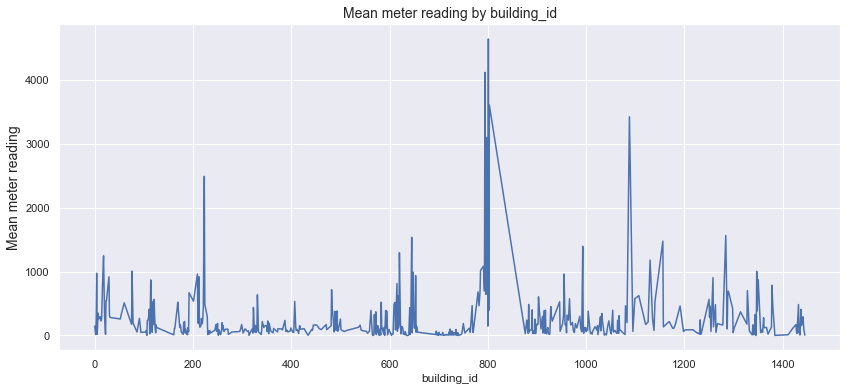

In [58]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train.groupby('building_id')['meter_reading'].mean().plot();
axes.set_title('Mean meter reading by building_id', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);

**El building_ip 1099 tiene un consumo de vapor enorme. en la electrica no se da cuenta**

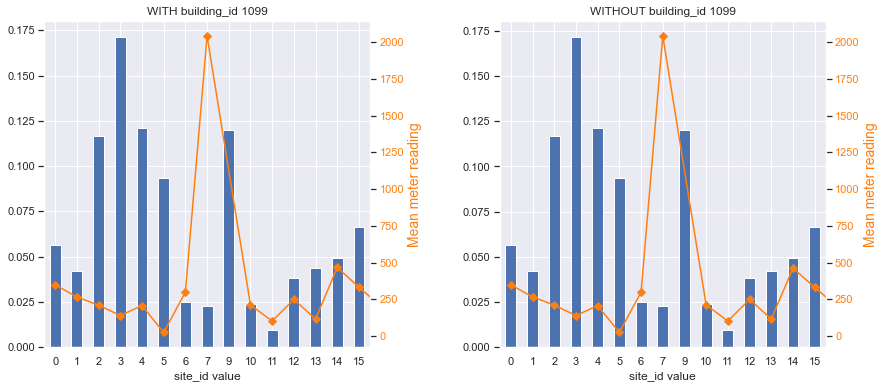

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
train['site_id'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[0]).set_xlabel('site_id value');
train[train['building_id']!=1099]['site_id'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[1]).set_xlabel('site_id value');
ax2 = axes[0].twinx()
ax3 = axes[1].twinx()
train.groupby('site_id')['meter_reading'].mean().sort_index().plot(ax=ax2, style='D-', grid=False, color='tab:orange');
train[train['building_id']!=1099].groupby('site_id')['meter_reading'].mean().sort_index().plot(ax=ax3, style='D-', grid=False, color='tab:orange');
ax2.set_ylabel('Mean meter reading', color='tab:orange', fontsize=14);
ax3.set_ylabel('Mean meter reading', color='tab:orange', fontsize=14);
ax2.tick_params(axis='y', labelcolor='tab:orange');
ax3.tick_params(axis='y', labelcolor='tab:orange');
plt.subplots_adjust(wspace=0.4)
axes[0].set_title('WITH building_id 1099');
axes[1].set_title('WITHOUT building_id 1099');

**year_built**

year_built - Year building was opened

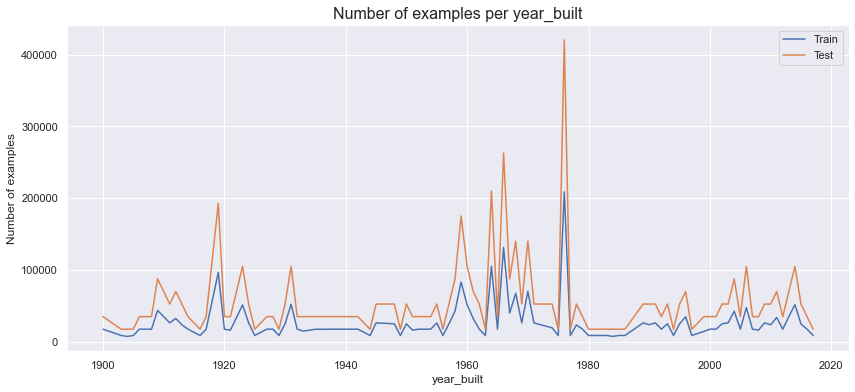

In [62]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train['year_built'].value_counts(dropna=False).sort_index().plot(ax=axes).set_xlabel('year_built');
test['year_built'].value_counts(dropna=False).sort_index().plot(ax=axes).set_ylabel('Number of examples');
axes.legend(['Train', 'Test']);
axes.set_title('Number of examples per year_built', fontsize=16);

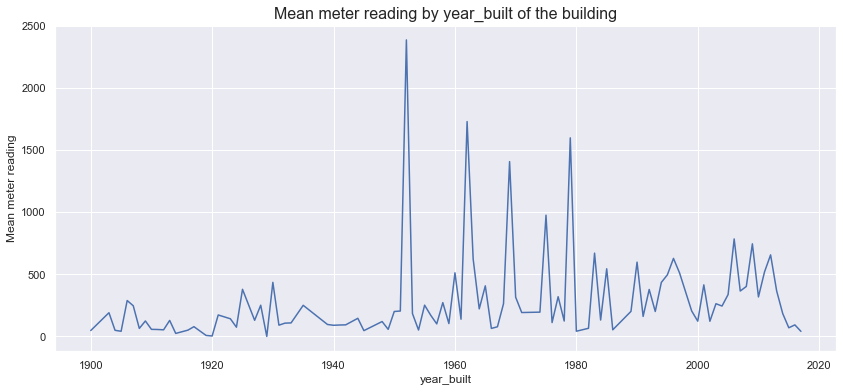

In [63]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train.groupby('year_built')['meter_reading'].mean().plot().set_ylabel('Mean meter reading');
axes.set_title('Mean meter reading by year_built of the building', fontsize=16);

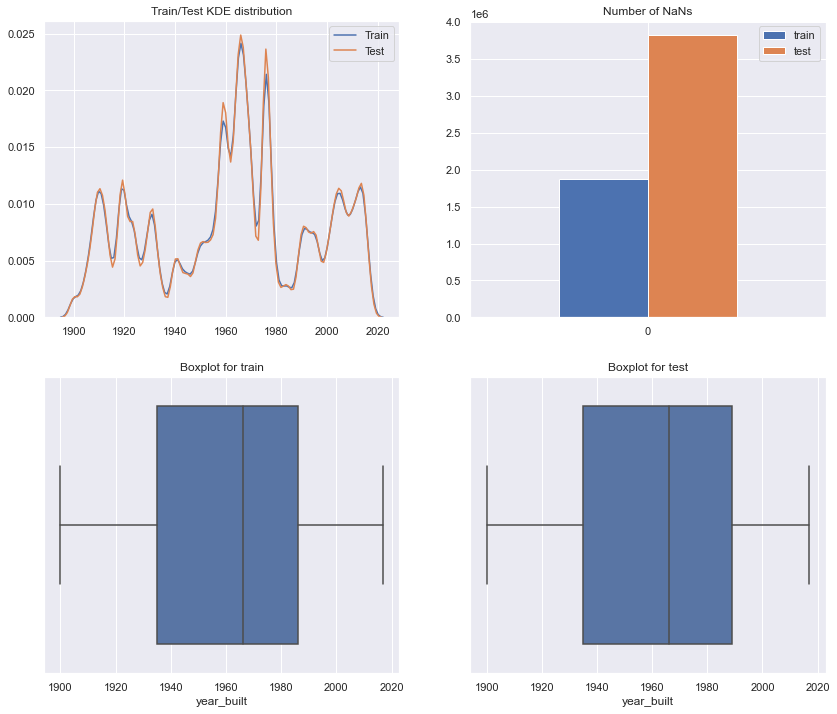

In [64]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
sns.kdeplot(train['year_built'], ax=axes[0][0], label='Train');
sns.kdeplot(test['year_built'], ax=axes[0][0], label='Test');
sns.boxplot(x=train['year_built'], ax=axes[1][0]);
sns.boxplot(x=test['year_built'], ax=axes[1][1]);
pd.DataFrame({'train': [train['year_built'].isnull().sum()], 'test': [test['year_built'].isnull().sum()]}).plot(kind='bar', rot=0, ax=axes[0][1]);
axes[0][0].legend();
axes[0][0].set_title('Train/Test KDE distribution');
axes[0][1].set_title('Number of NaNs');
axes[1][0].set_title('Boxplot for train');
axes[1][1].set_title('Boxplot for test');
gc.collect();

**floor_count**
floor_count - Number of floors of the building

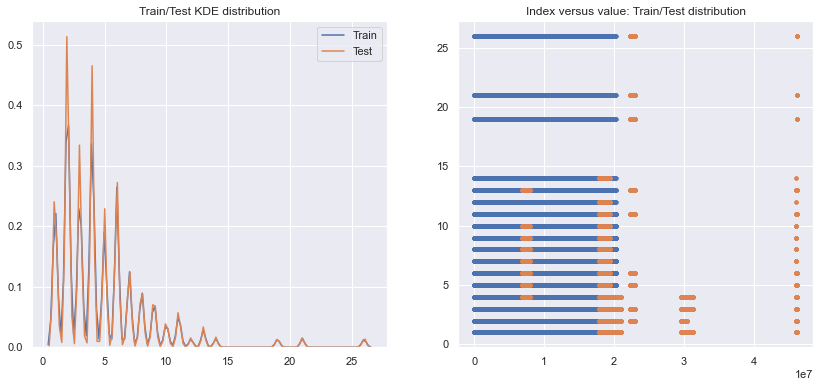

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.kdeplot(train['floor_count'], label='Train', ax=axes[0]);
sns.kdeplot(test['floor_count'], label='Test', ax=axes[0]);
test.index += len(train)
axes[1].plot(train['floor_count'], '.', label='Train');
axes[1].plot(test['floor_count'], '.', label='Test');
test.index -= len(train)
axes[0].set_title('Train/Test KDE distribution');
axes[1].set_title('Index versus value: Train/Test distribution');
gc.collect();

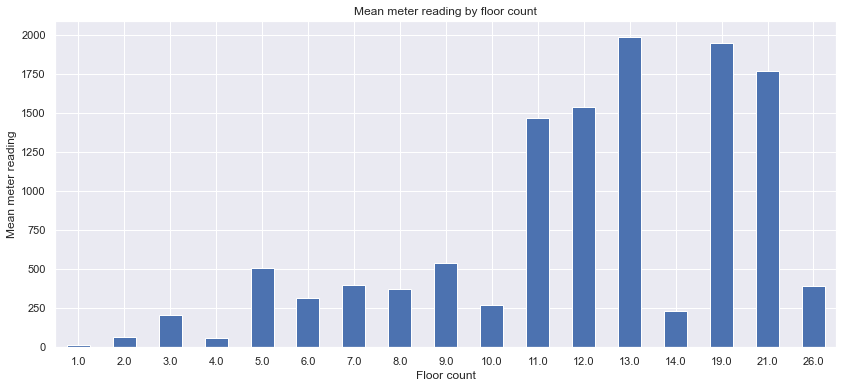

In [66]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
pd.Series(index=train['floor_count'].value_counts().index, 
          data=train.groupby('floor_count')['meter_reading'].transform('mean').value_counts().index).sort_index().plot(kind='bar', rot=0, ax=axes);
axes.set_xlabel('Floor count');
axes.set_ylabel('Mean meter reading');
axes.set_title('Mean meter reading by floor count');

**Number of NaNs in floor_count**

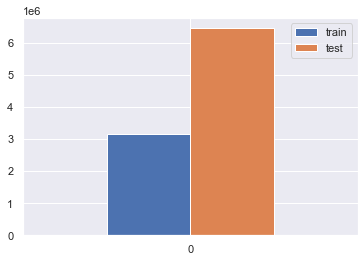

In [67]:
pd.DataFrame({'train': [train['floor_count'].isnull().sum()], 'test': [test['floor_count'].isnull().sum()]}).plot(kind='bar', rot=0);

**air_temperature**

air_temperature - Degrees Celsius

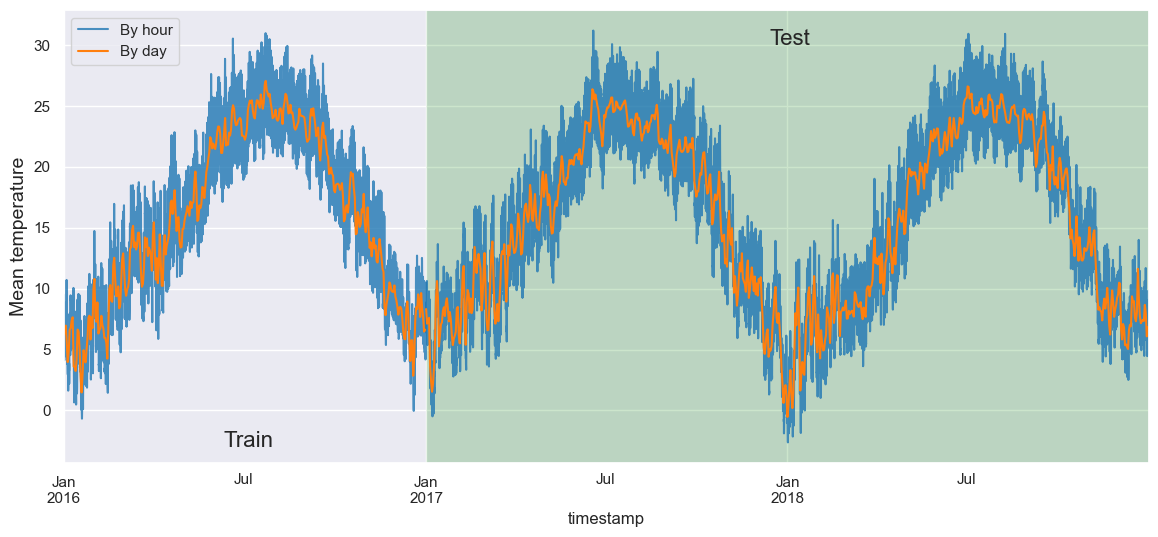

In [80]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
train[['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean temperature', fontsize=14);
test[['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes, alpha=0.8, color='tab:blue', label='');
train[['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes, alpha=1, label='By day', color='tab:orange');
test[['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes, alpha=1, color='tab:orange', label='');
axes.legend();
axes.text(train['timestamp'].iloc[2000000], -3, 'Train', fontsize=16);
axes.text(test['timestamp'].iloc[2740000], 30, 'Test', fontsize=16);
axes.axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='green', alpha=0.2);

Air temperature by site_id. Looks like some sites are more to north and some more to south.

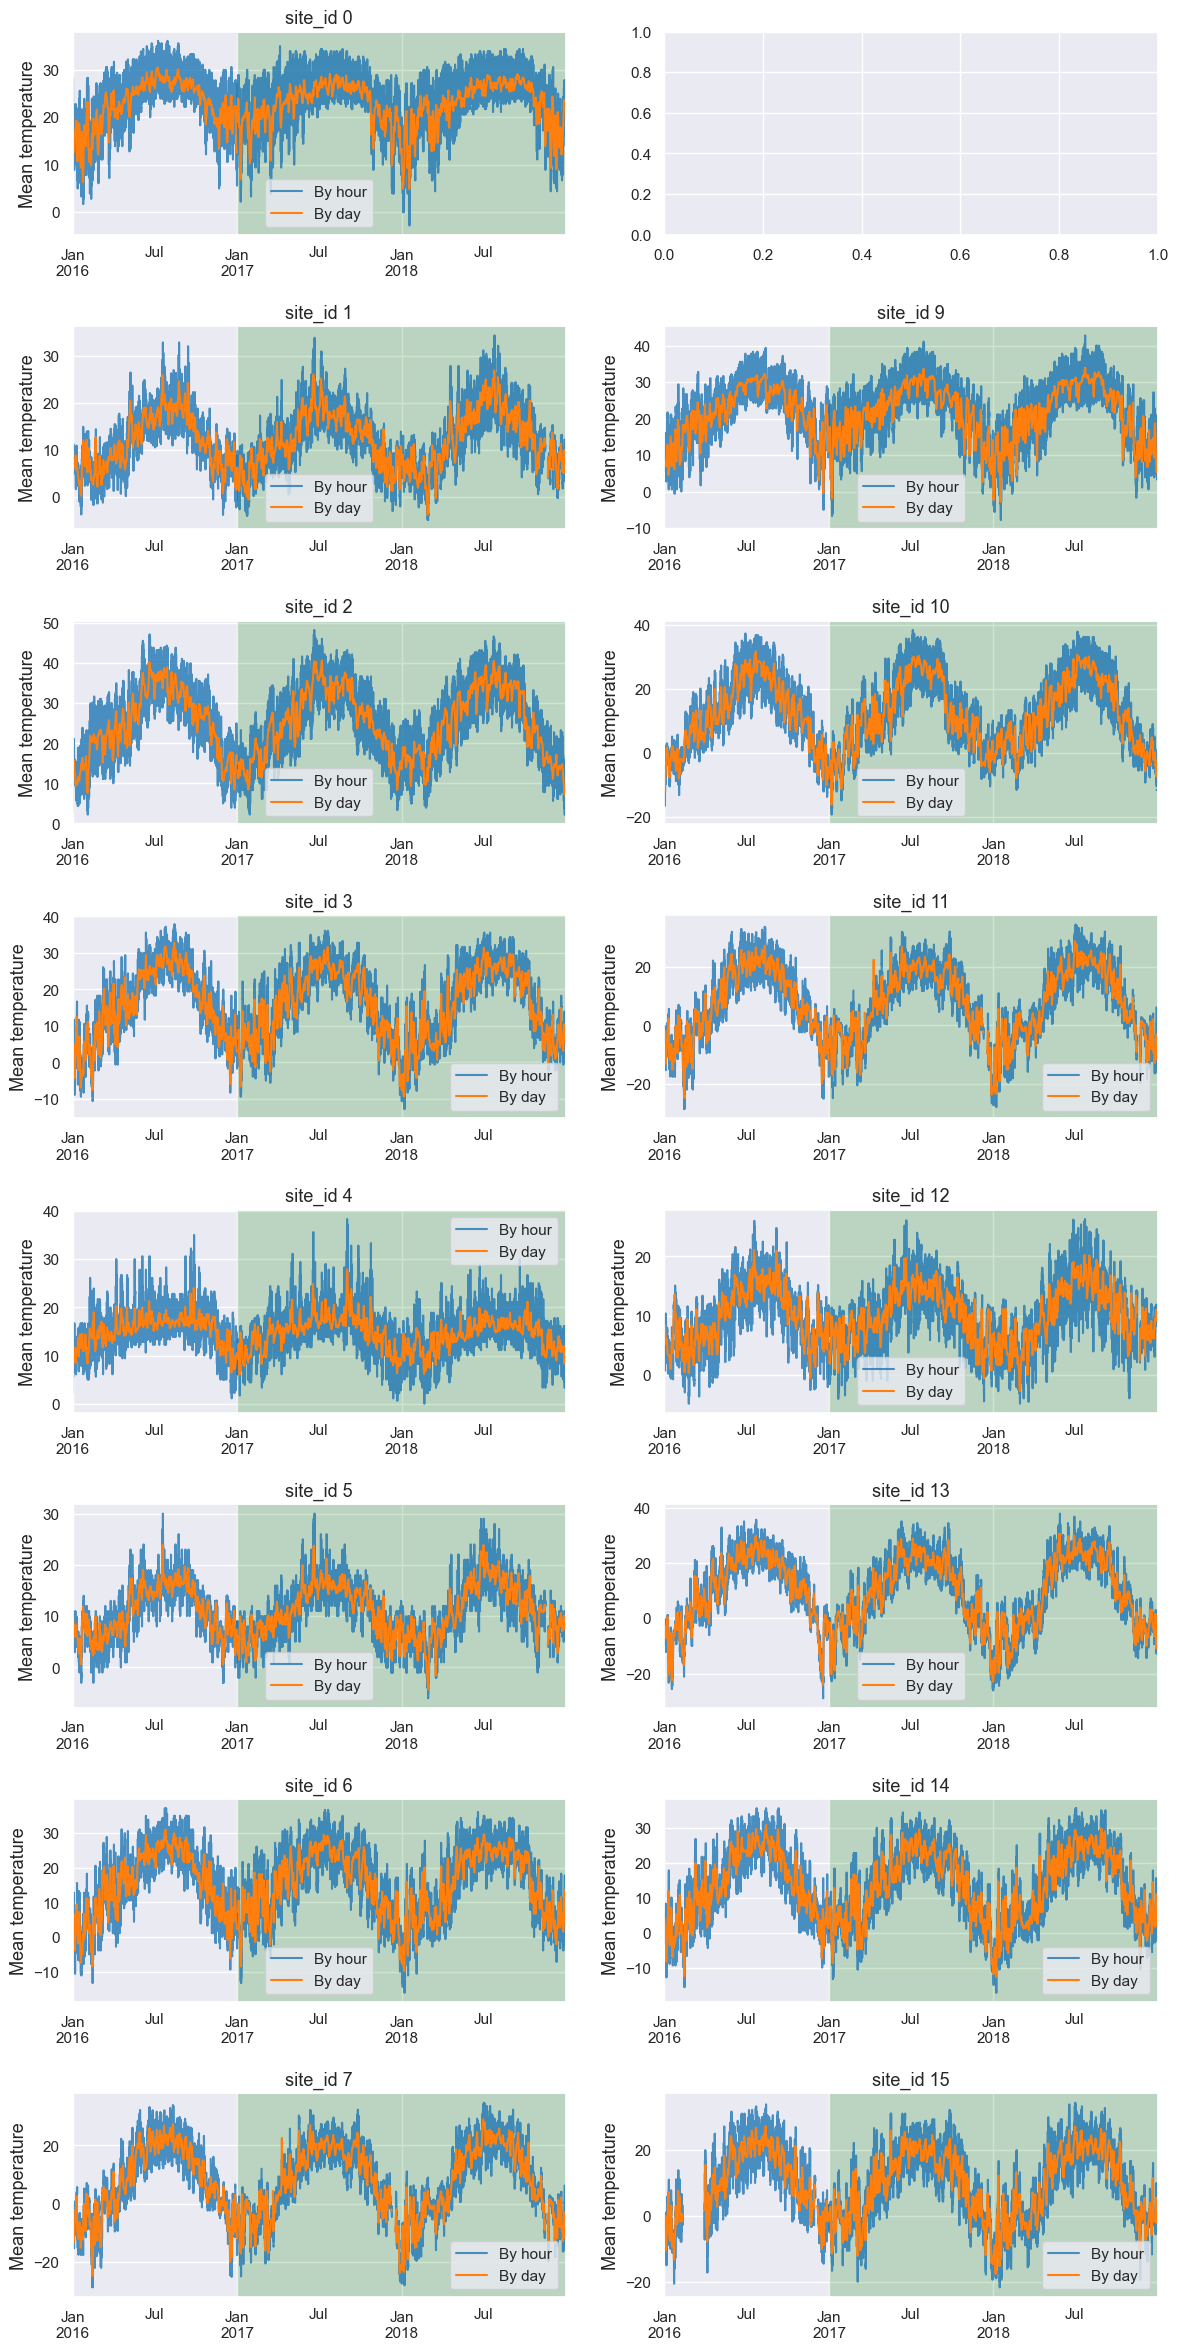

In [83]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i in range(16):
    if i == 8:
        continue
    
    train[train['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean temperature', fontsize=13);
    test[test['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes[i%8][i//8], alpha=0.8, color='tab:blue', label='').set_xlabel('')
    train[train['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange')
    test[test['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes[i%8][i//8], alpha=1, color='tab:orange', label='').set_xlabel('')
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    axes[i%8][i//8].axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='green', alpha=0.2);
    plt.subplots_adjust(hspace=0.45)

**cloud_coverage**

cloud_coverage - Portion of the sky covered in clouds, in oktas

https://en.wikipedia.org/wiki/Okta

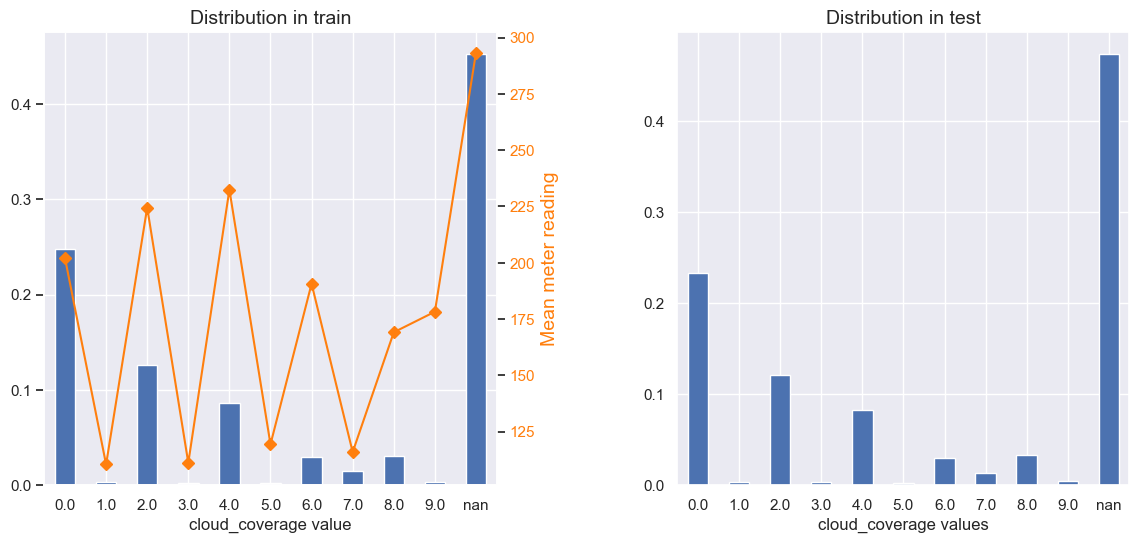

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100)
train['cloud_coverage'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[0]).set_xlabel('cloud_coverage value');
test['cloud_coverage'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[1]).set_xlabel('cloud_coverage values');
axes[0].set_title('Distribution in train', fontsize=14);
axes[1].set_title('Distribution in test', fontsize=14);
ax2 = axes[0].twinx()
train[['cloud_coverage', 'meter_reading']].replace(np.nan, 'nan').groupby('cloud_coverage')['meter_reading'].mean().plot(ax=ax2, style='D-', grid=False, color='tab:orange');
ax2.tick_params(axis='y', labelcolor='tab:orange');
ax2.set_ylabel('Mean meter reading', color='tab:orange', fontsize=14);
ax2.set_xticklabels(train['cloud_coverage'].value_counts(dropna=False).sort_index().index)
plt.subplots_adjust(wspace=0.4);

dew_temperature

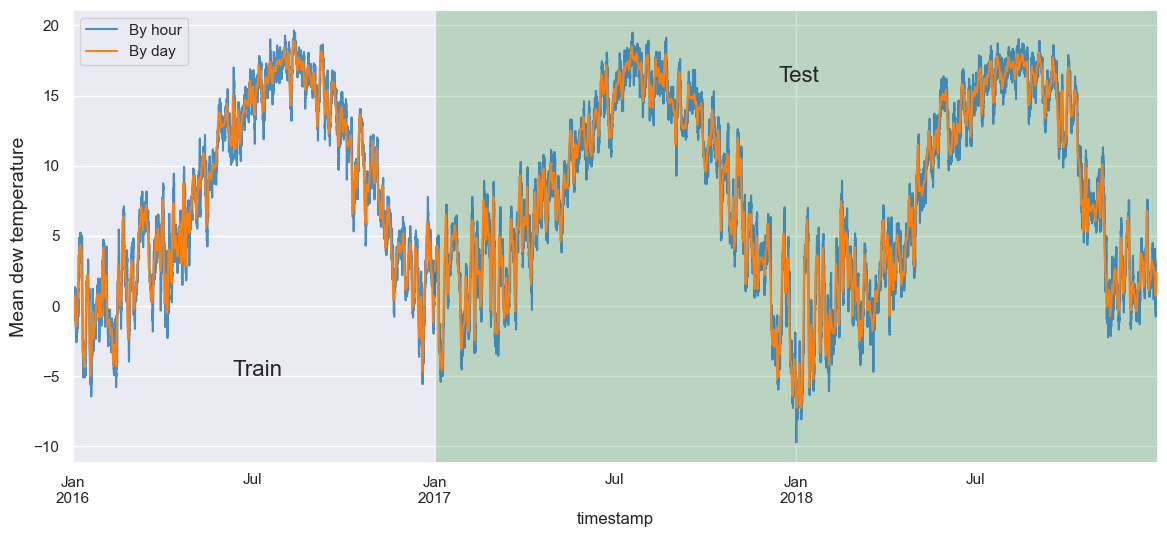

In [93]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
train[['timestamp', 'dew_temperature']].set_index('timestamp').resample('H').mean()['dew_temperature'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean dew temperature', fontsize=14);
test[['timestamp', 'dew_temperature']].set_index('timestamp').resample('H').mean()['dew_temperature'].plot(ax=axes, alpha=0.8, color='tab:blue', label='');
train[['timestamp', 'dew_temperature']].set_index('timestamp').resample('D').mean()['dew_temperature'].plot(ax=axes, alpha=1, label='By day', color='tab:orange');
test[['timestamp', 'dew_temperature']].set_index('timestamp').resample('D').mean()['dew_temperature'].plot(ax=axes, alpha=1, color='tab:orange', label='');
axes.legend();
axes.text(train['timestamp'].iloc[2000000], -5, 'Train', fontsize=16);
axes.text(test['timestamp'].iloc[2740000], 16, 'Test', fontsize=16);
axes.axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='green', alpha=0.2);

Mean dew temperature by site_id

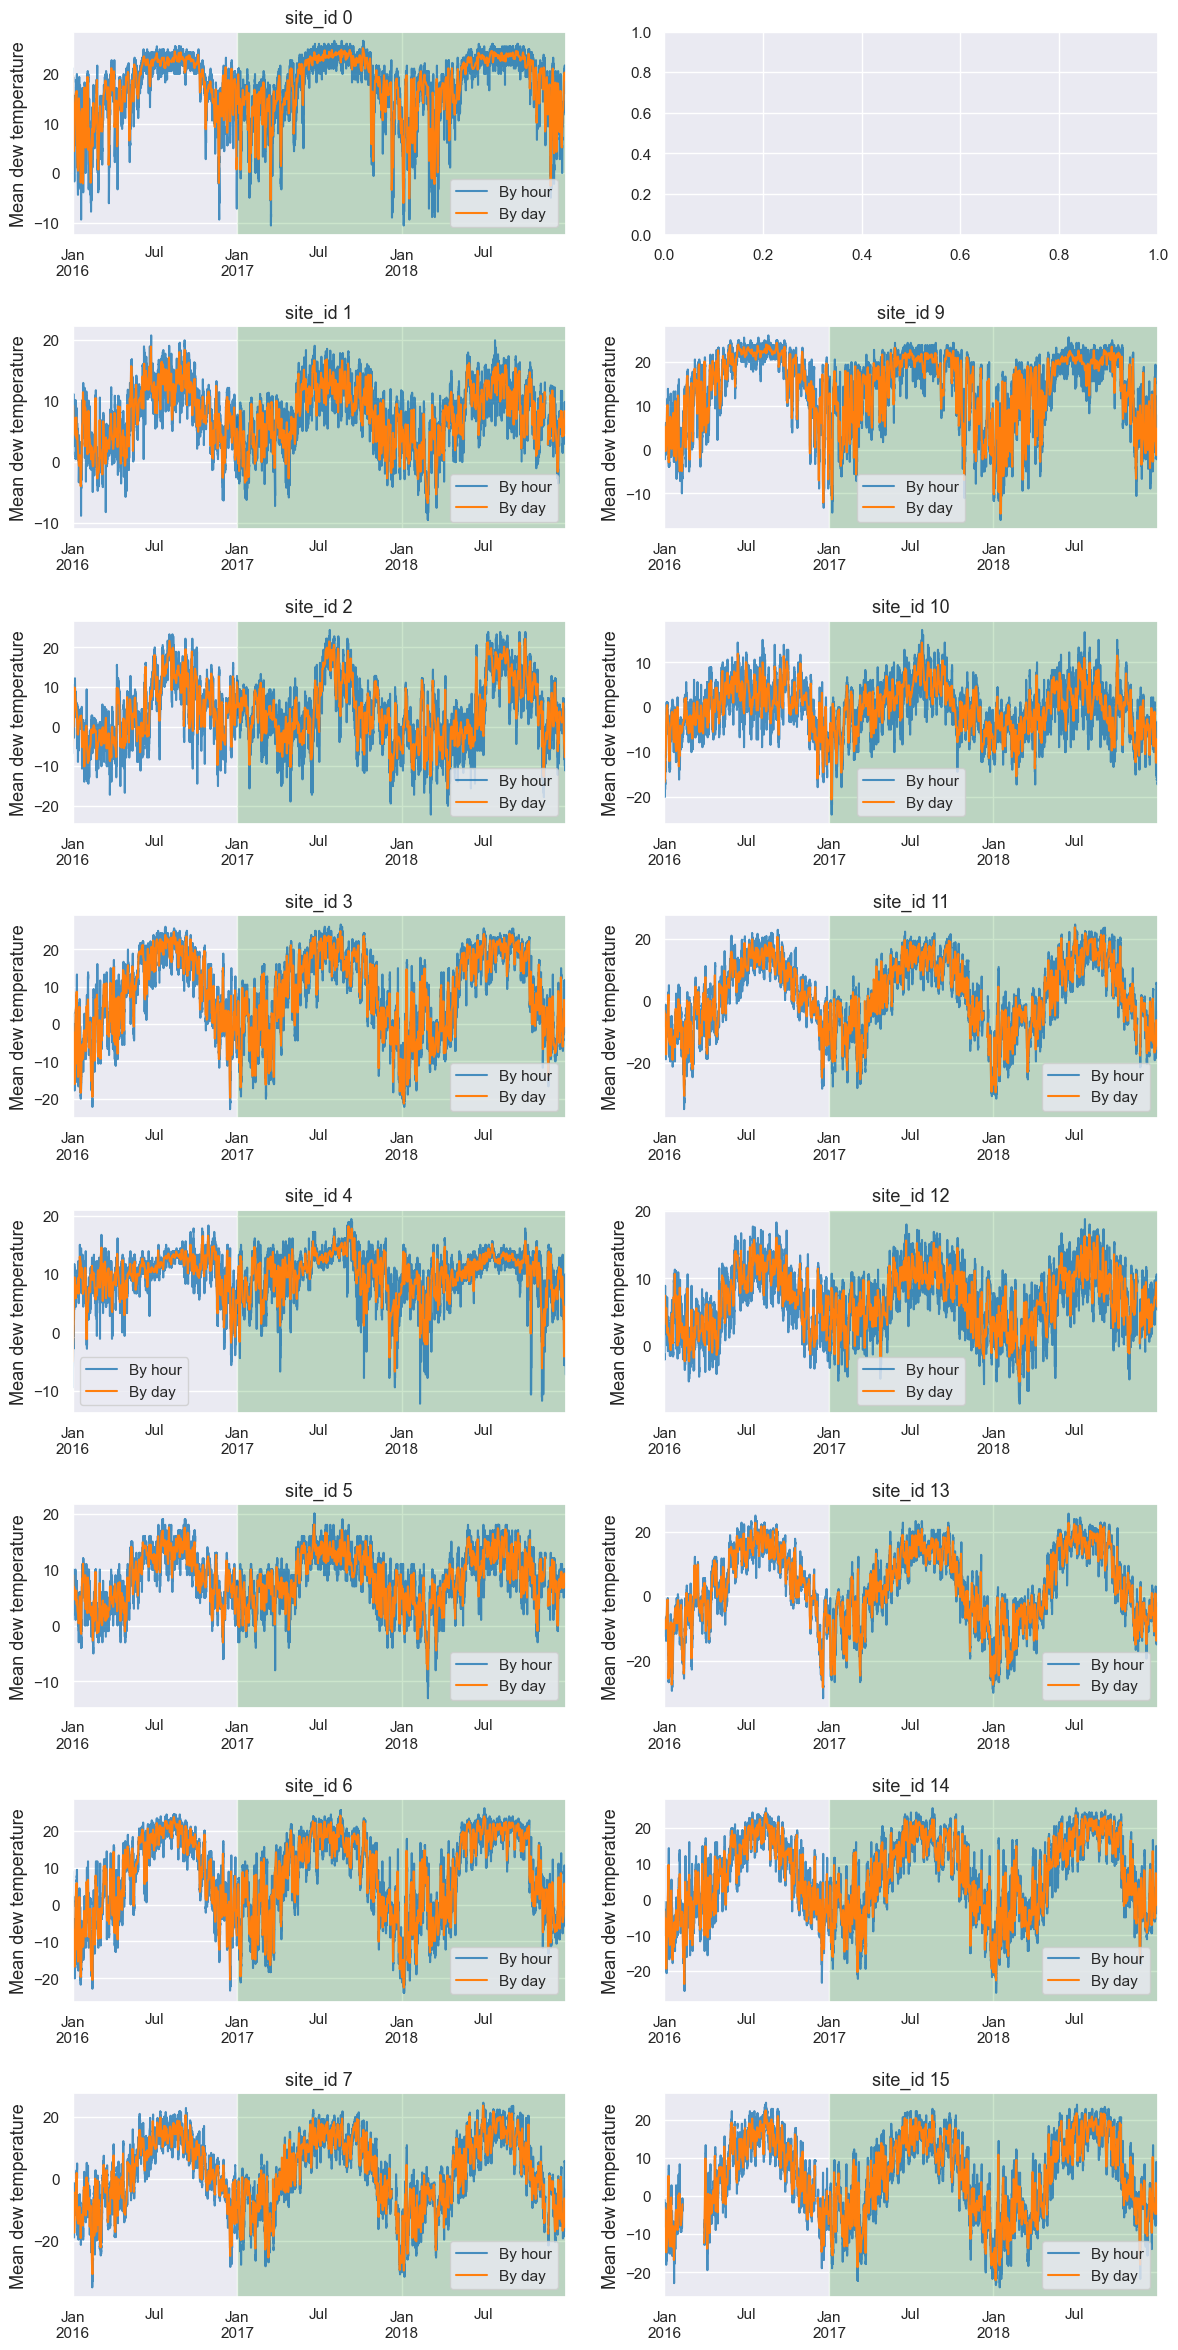

In [97]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i in range(16):
    if i == 8:
        continue
    
    train[train['site_id'] == i][['timestamp', 'dew_temperature']].set_index('timestamp').resample('H').mean()['dew_temperature'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean dew temperature', fontsize=13);
    test[test['site_id'] == i][['timestamp', 'dew_temperature']].set_index('timestamp').resample('H').mean()['dew_temperature'].plot(ax=axes[i%8][i//8], alpha=0.8, color='tab:blue', label='').set_xlabel('')
    train[train['site_id'] == i][['timestamp', 'dew_temperature']].set_index('timestamp').resample('D').mean()['dew_temperature'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange')
    test[test['site_id'] == i][['timestamp', 'dew_temperature']].set_index('timestamp').resample('D').mean()['dew_temperature'].plot(ax=axes[i%8][i//8], alpha=1, color='tab:orange', label='').set_xlabel('')
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    axes[i%8][i//8].axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='green', alpha=0.2);
    plt.subplots_adjust(hspace=0.45)

**precip_depth_1_hr**

precip_depth_1_hr - Millimeters

There are plenty of NaNs and you can see on the following plot that there is no information for Decemder 2016 - January 2017.

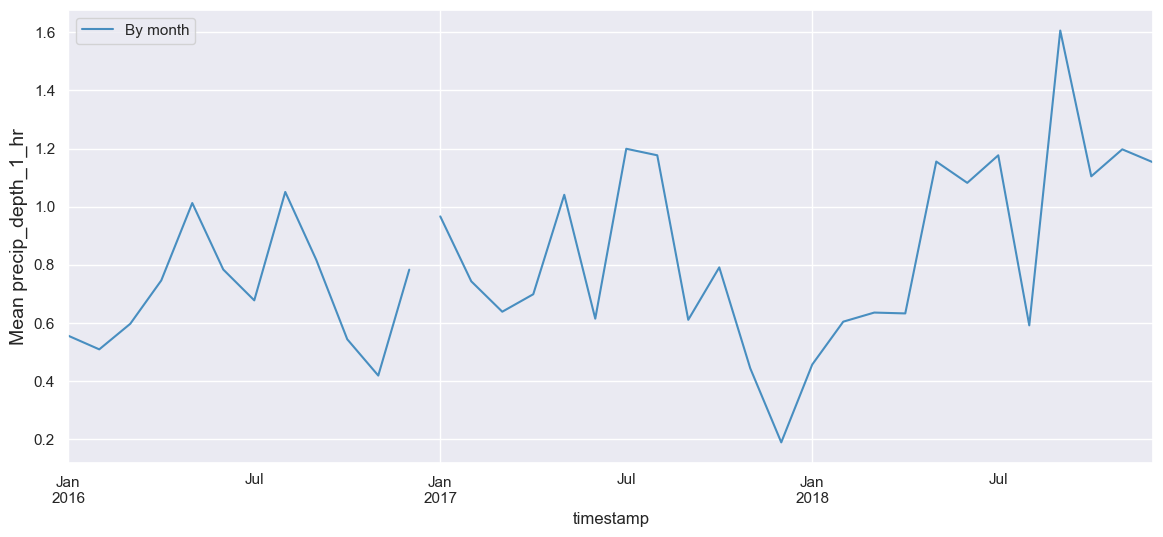

In [95]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
train[['timestamp', 'precip_depth_1_hr']].set_index('timestamp').resample('M').mean()['precip_depth_1_hr'].plot(ax=axes, alpha=0.8, label='By month', color='tab:blue').set_ylabel('Mean precip_depth_1_hr', fontsize=14);
test[['timestamp', 'precip_depth_1_hr']].set_index('timestamp').resample('M').mean()['precip_depth_1_hr'].plot(ax=axes, alpha=0.8, color='tab:blue', label='');
axes.legend();

**sea_level_pressure**

sea_level_pressure - Millibar/hectopascals

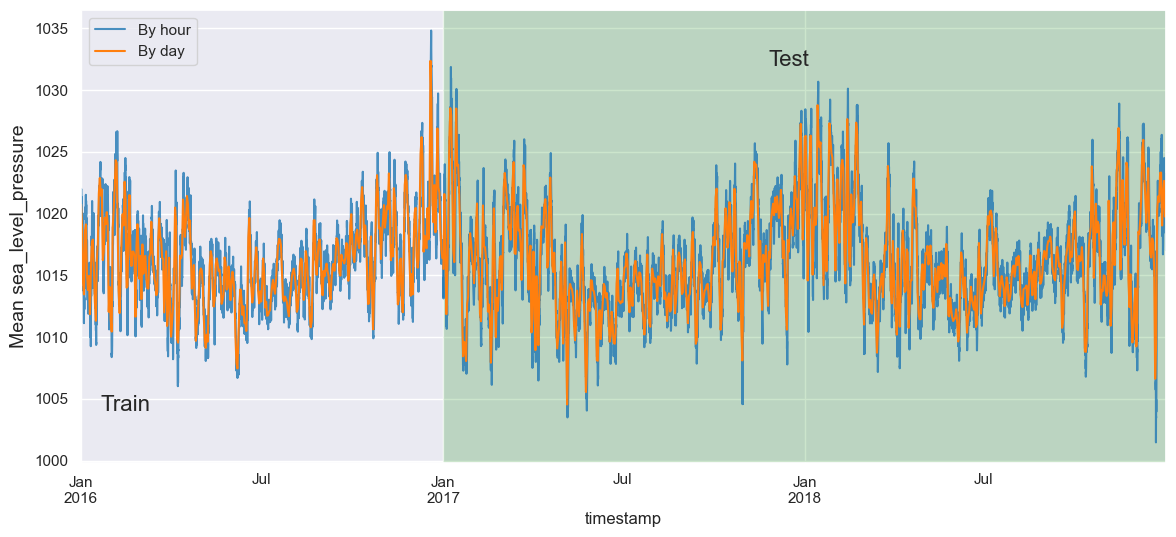

In [98]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
train[['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('H').mean()['sea_level_pressure'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean sea_level_pressure', fontsize=14);
test[['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('H').mean()['sea_level_pressure'].plot(ax=axes, alpha=0.8, color='tab:blue', label='');
train[['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('D').mean()['sea_level_pressure'].plot(ax=axes, alpha=1, label='By day', color='tab:orange');
test[['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('D').mean()['sea_level_pressure'].plot(ax=axes, alpha=1, color='tab:orange', label='');
axes.legend();
axes.text(train['timestamp'].iloc[250000], 1004, 'Train', fontsize=16);
axes.text(test['timestamp'].iloc[2700000], 1032, 'Test', fontsize=16);
axes.axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='green', alpha=0.2);

And separate by site_id

As we can see all values for site_id 5 are NaNs. Maybe there is no a pressure meter installed in that area?

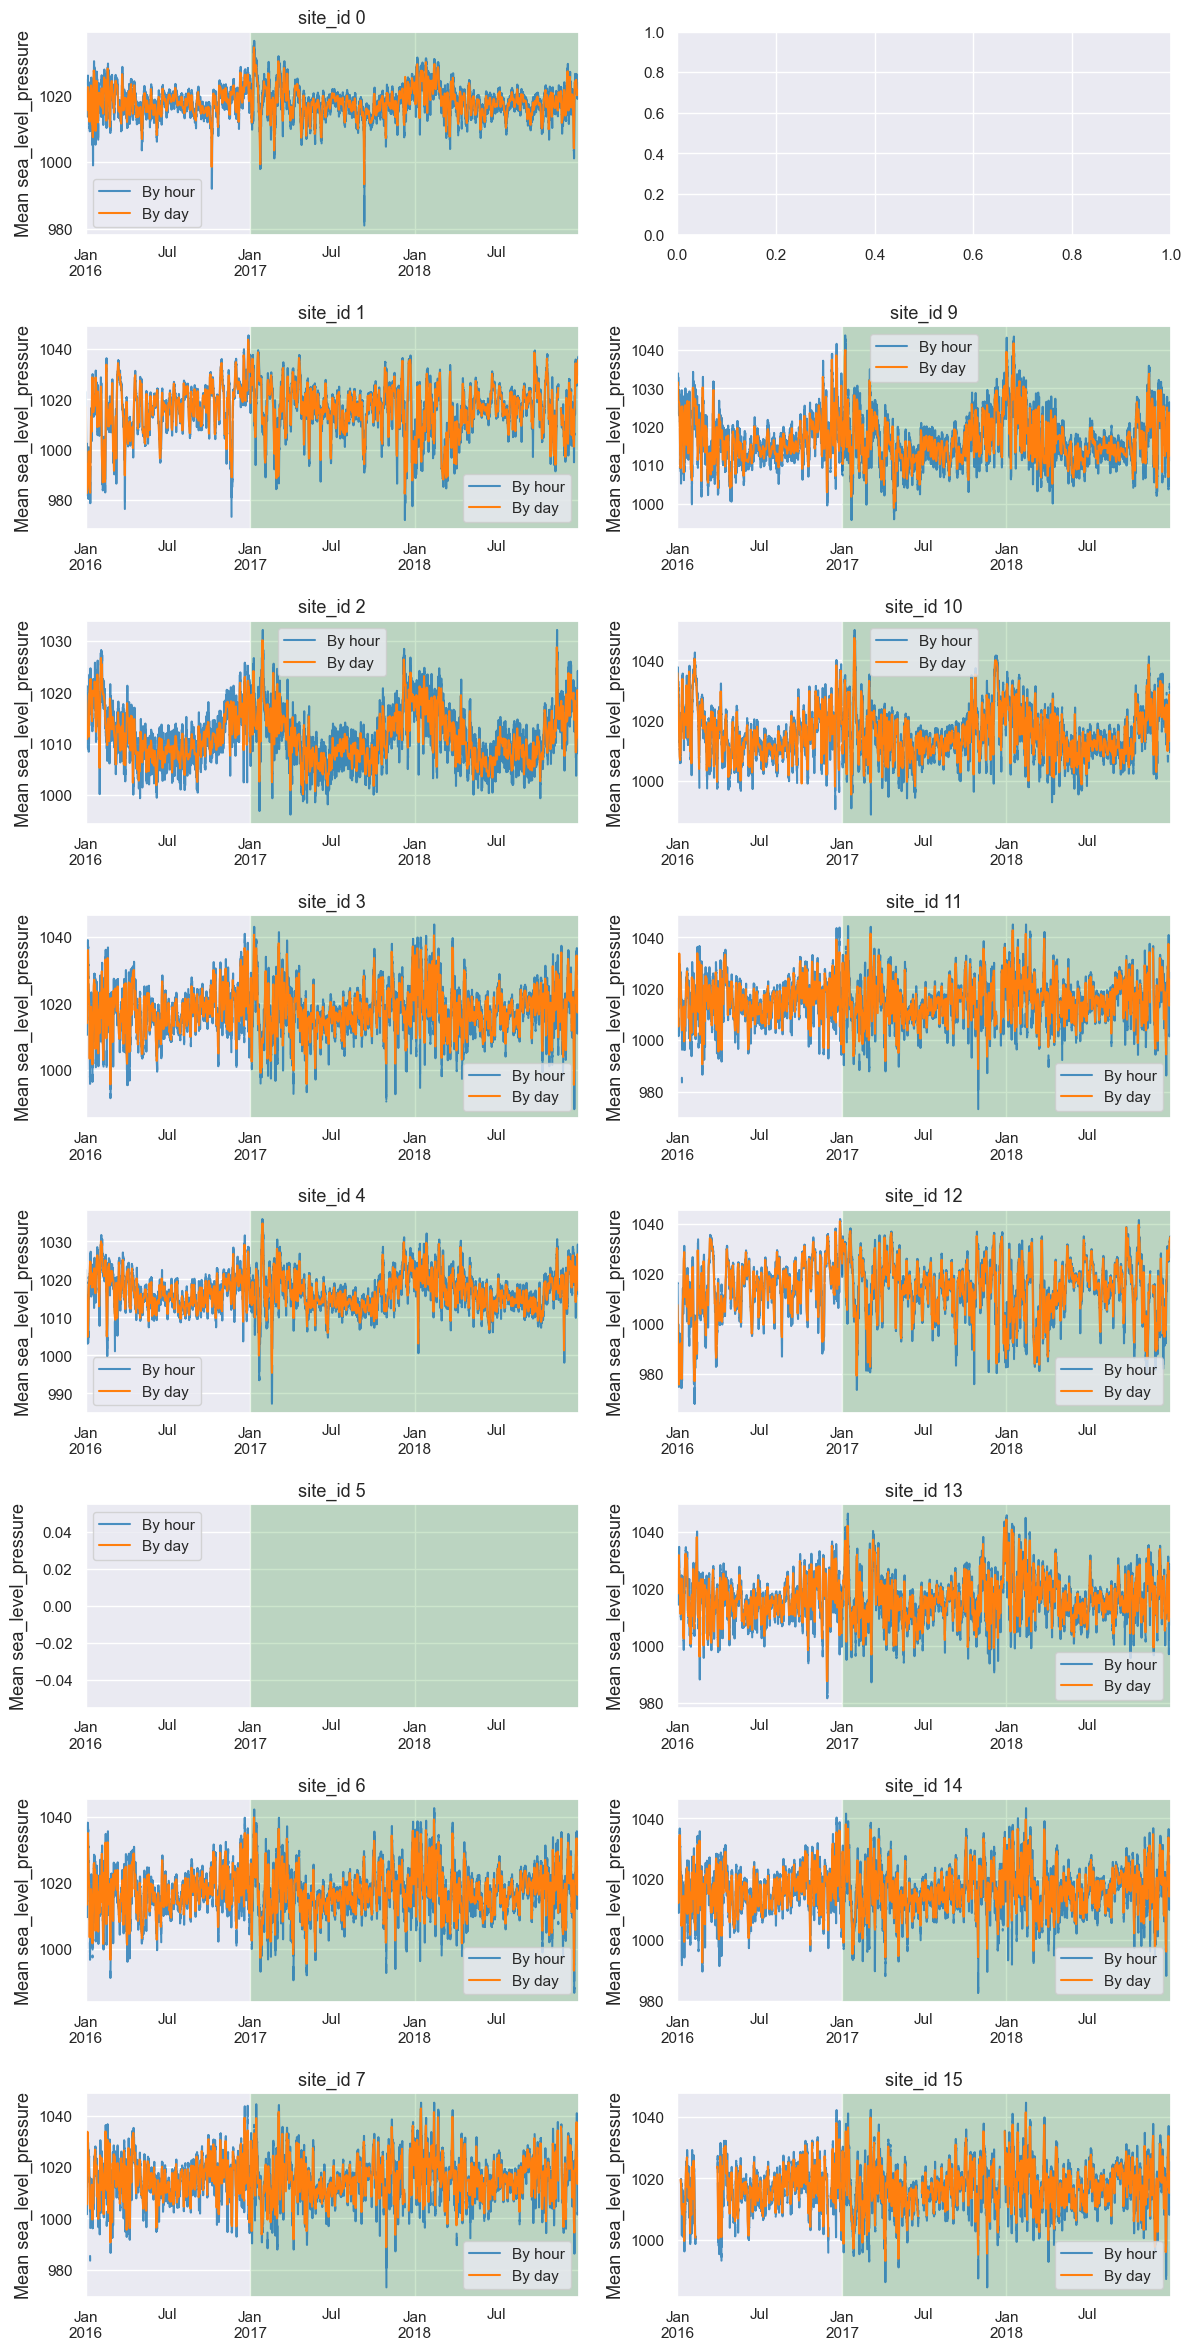

In [99]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i in range(16):
    if i == 8:
        continue
    train[train['site_id'] == i][['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('H').mean()['sea_level_pressure'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean sea_level_pressure', fontsize=13);
    test[test['site_id'] == i][['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('H').mean()['sea_level_pressure'].plot(ax=axes[i%8][i//8], alpha=0.8, color='tab:blue', label='').set_xlabel('')
    train[train['site_id'] == i][['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('D').mean()['sea_level_pressure'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange')
    test[test['site_id'] == i][['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('D').mean()['sea_level_pressure'].plot(ax=axes[i%8][i//8], alpha=1, color='tab:orange', label='').set_xlabel('')
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    axes[i%8][i//8].axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='green', alpha=0.2);
    plt.subplots_adjust(hspace=0.45)

**wind_direction & wind_speed**

wind_direction - Compass direction (0-360)

wind_speed - Meters per second

Ok, plotting this is tricky, so I am going to do it using this manual

First of all: direction of 0° and 360° is the same thing. But both are presented in the datasets.

In [100]:
print('Number of observations with 0 degree direction in TRAIN: {} ({:.2f}%)'.format(train[train['wind_direction'] == 0].shape[0], train[train['wind_direction'] == 0].shape[0] / len(train)))
print('Number of observations with 0 degree direction in TEST: {} ({:.2f}%)'.format(test[test['wind_direction'] == 0].shape[0], test[test['wind_direction'] == 0].shape[0] / len(test)))
print('Number of observations with 360 degree direction in TRAIN: {} ({:.2f}%)'.format(train[train['wind_direction'] == 360].shape[0], train[train['wind_direction'] == 360].shape[0] / len(train)))
print('Number of observations with 360 degree direction in TEST: {} ({:.2f}%)'.format(test[test['wind_direction'] == 360].shape[0], test[test['wind_direction'] == 360].shape[0] / len(test)))

Number of observations with 0 degree direction in TRAIN: 478207 (0.10%)
Number of observations with 0 degree direction in TEST: 964294 (0.10%)
Number of observations with 360 degree direction in TRAIN: 85778 (0.02%)
Number of observations with 360 degree direction in TEST: 162335 (0.02%)


Now lets see how many observations have calm conditions (wind speed is 0 meters per second)

In [101]:
print('Number of observations that have calm conditions in TRAIN: {} ({:.2f}%)'.format(train[train['wind_speed'] == 0].shape[0], train[train['wind_speed'] == 0].shape[0] / len(train)))
print('Number of observations that have calm conditions in TEST: {} ({:.2f}%)'.format(test[test['wind_speed'] == 0].shape[0], test[test['wind_speed'] == 0].shape[0] / len(test)))

Number of observations that have calm conditions in TRAIN: 481532 (0.10%)
Number of observations that have calm conditions in TEST: 971799 (0.10%)


In [103]:
def speed_labels(bins:list, units:str) -> list:   
    labels = list()
    for left, right in zip(bins[:-1], bins[1:]):
        if left == bins[0]:
            labels.append('calm'.format(right))
        elif np.isinf(right):
            labels.append('>{} {}'.format(left, units))
        else:
            labels.append('{} - {} {}'.format(left, right, units))
    return labels

def _convert_dir(directions, N=None):
    if N is None:
        N = directions.shape[0]
    barDir = directions * np.pi/180. - np.pi/N
    barWidth = 2 * np.pi / N
    return barDir, barWidth

spd_bins = [-1, 0, 5, 10, 15, 20, 25, 30, np.inf]
spd_labels = speed_labels(spd_bins, units='m/s')

dir_bins = np.arange(-7.5, 370, 15)
dir_labels = (dir_bins[:-1] + dir_bins[1:]) / 2

In [104]:
calm_count = train[train['wind_speed'] == 0].shape[0]
total_count = len(train)
rose = (train.assign(WindSpd_bins=lambda df:
            pd.cut(df['wind_speed'], bins=spd_bins, labels=spd_labels, right=True)).assign(WindDir_bins=lambda df: pd.cut(df['wind_direction'], bins=dir_bins, labels=dir_labels, right=False)).replace({'WindDir_bins': {360: 0}}).groupby(by=['WindSpd_bins', 'WindDir_bins']).size().unstack(level='WindSpd_bins').fillna(0).assign(calm=lambda df: calm_count / df.shape[0]).sort_index(axis=1).applymap(lambda x: x / total_count * 100))
rose.drop(rose.index[0], inplace=True)
directions = np.arange(0, 360, 15)

In [105]:
def wind_rose(rosedata, wind_dirs, palette=None):
    if palette is None:
        palette = sns.color_palette('inferno', n_colors=rosedata.shape[1])

    bar_dir, bar_width = _convert_dir(wind_dirs)

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')

    for n, (c1, c2) in enumerate(zip(rosedata.columns[:-1], rosedata.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(bar_dir, rosedata[c1].values, 
                   width=bar_width,
                   color=palette[0],
                   edgecolor='none',
                   label=c1,
                   linewidth=0)

        # all other columns
        ax.bar(bar_dir, rosedata[c2].values, 
               width=bar_width, 
               bottom=rosedata.cumsum(axis=1)[c1].values,
               color=palette[n+1],
               edgecolor='none',
               label=c2,
               linewidth=0)

    leg = ax.legend(loc=(0.75, 0.95), ncol=2)
    xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    
    return fig

This is a wind rose for TRAIN:

ValueError: shape mismatch: objects cannot be broadcast to a single shape

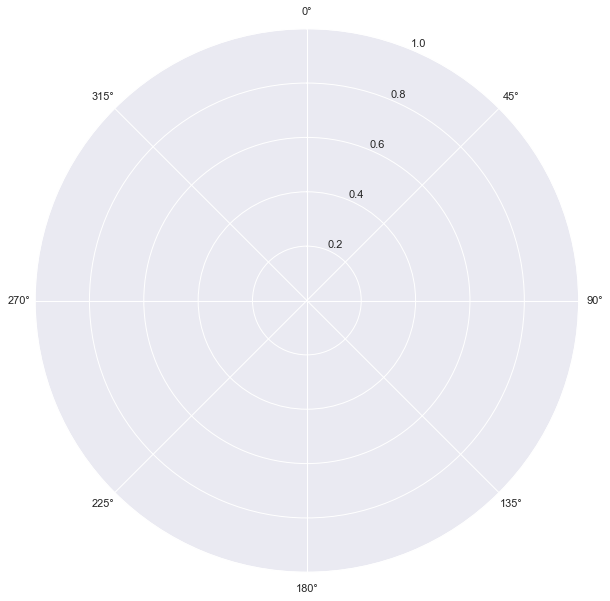

In [106]:
fig = wind_rose(rose, directions)

**Engineered features** 

Now lets add some new features and see if they might be usefull. First I am going to work with timeseries data.

Observation hour
An hour the meter reading was recorded.

In [107]:
train['hour'] = train['timestamp'].dt.hour
test['hour'] = test['timestamp'].dt.hour

One more evidence that train and test datasets are very well balanced. Number of observations per hour is almost the same.

Also we can see that energy consumption raises up during the day and lowers during the night hours.

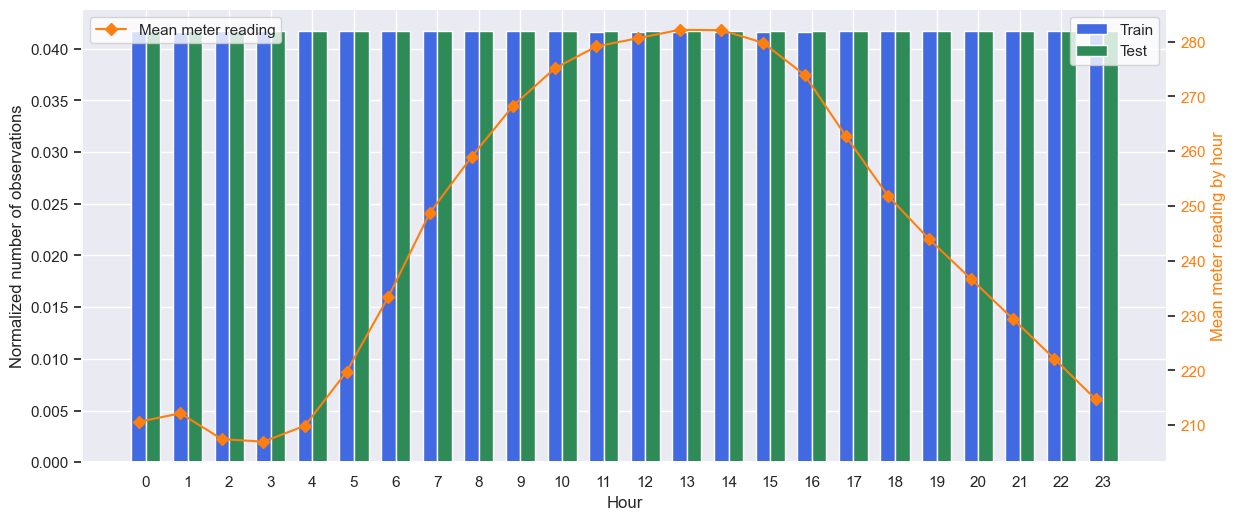

In [108]:
train_data = train['hour'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['hour'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('Hour');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['hour'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['hour', 'meter_reading']].groupby('hour')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by hour', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

**Observation day of month** 

A day of month the meter reading was recorded.

Number of observations for day 30 and 31 are lower than for other days, which makes sence - not every month have 30 or 31 days in it.

Also pay attention that number of observations for day 29 in training set is higher than in testing set. This is because training set contains observations of the year 2016, which was a leap year.

In [110]:
train['day'] = train['timestamp'].dt.day
test['day'] = test['timestamp'].dt.day

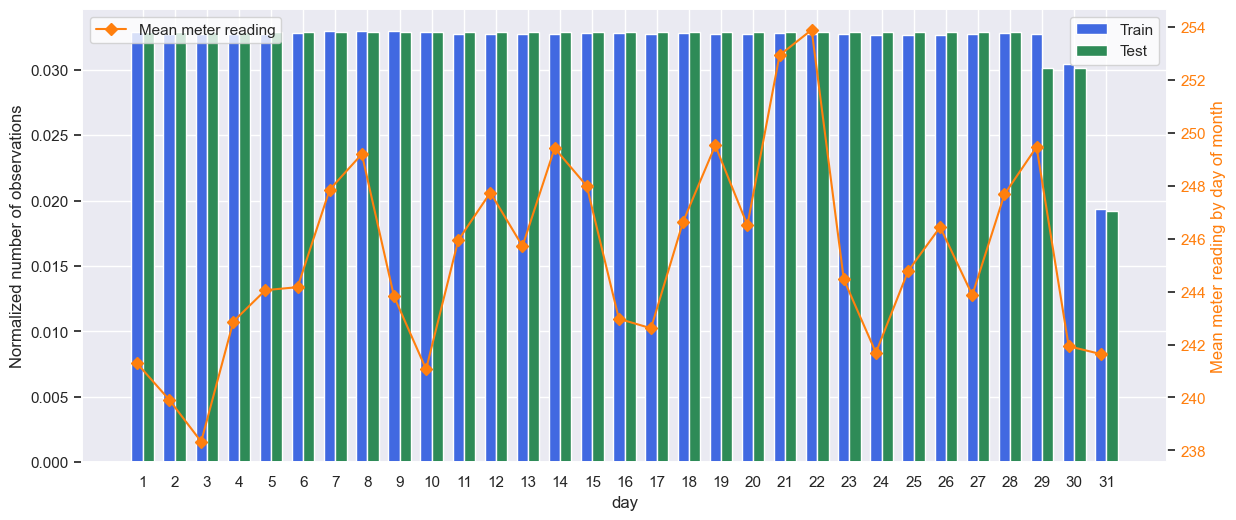

In [111]:
train_data = train['day'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['day'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('day');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['day'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['day', 'meter_reading']].groupby('day')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by day of month', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

Observation day of week

In [112]:
train['weekday'] = train['timestamp'].dt.weekday
test['weekday'] = test['timestamp'].dt.weekday

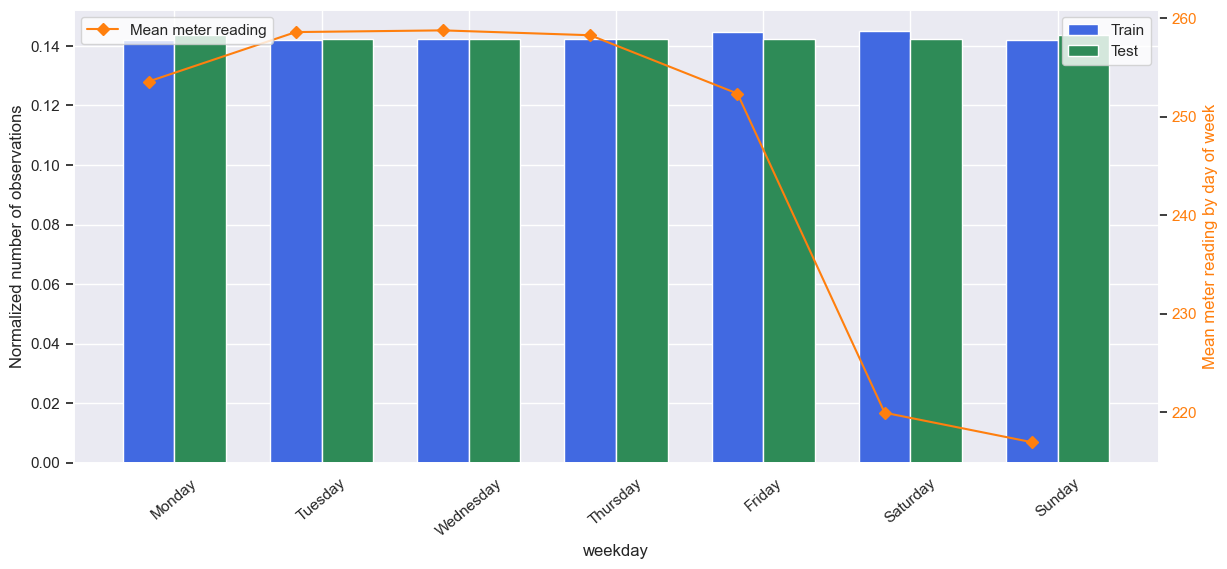

In [113]:
train_data = train['weekday'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['weekday'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('weekday');
axes.set_xticks(ind + width / 2)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['weekday', 'meter_reading']].groupby('weekday')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by day of week', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

axes.set_xticklabels(train['weekday'].value_counts().sort_index().index.map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}), rotation=40);

Genero DataSets sin outliers

In [122]:
def detect_outlier(data):
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(data), [25, 75])
    # compute IRQ
    iqr = q3 - q1
    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = [x for x in data if x <= lower_bound or x >= upper_bound]
    return (lower_bound,upper_bound)

(4597256, 19)

In [129]:
train_lower_bound, train_upper_bound = detect_outlier(train['meter_reading'])
test_lower_bound, test_upper_bound = detect_outlier(test['meter_reading'])

In [133]:
print([train_lower_bound,train_upper_bound])

upper_bound_mask = train['meter_reading'] <= train_upper_bound
train_ub = train.loc[upper_bound_mask,:]

lower_bound_mask = train['meter_reading'] >= lower_bound
train_lb = train.loc[lower_bound_mask,:]

print(train_ub.shape[0])
print(train_lb.shape[0])

[-298.4488125, 579.0692875]
4160882
4597256


In [142]:
train_lb.site_id.value_counts()

3     788160
4     557399
9     552209
2     535446
5     430416
15    305382
0     258480
14    227347
13    201898
1     193248
12    175669
6     113899
10    109519
7     104784
11     43400
Name: site_id, dtype: int64

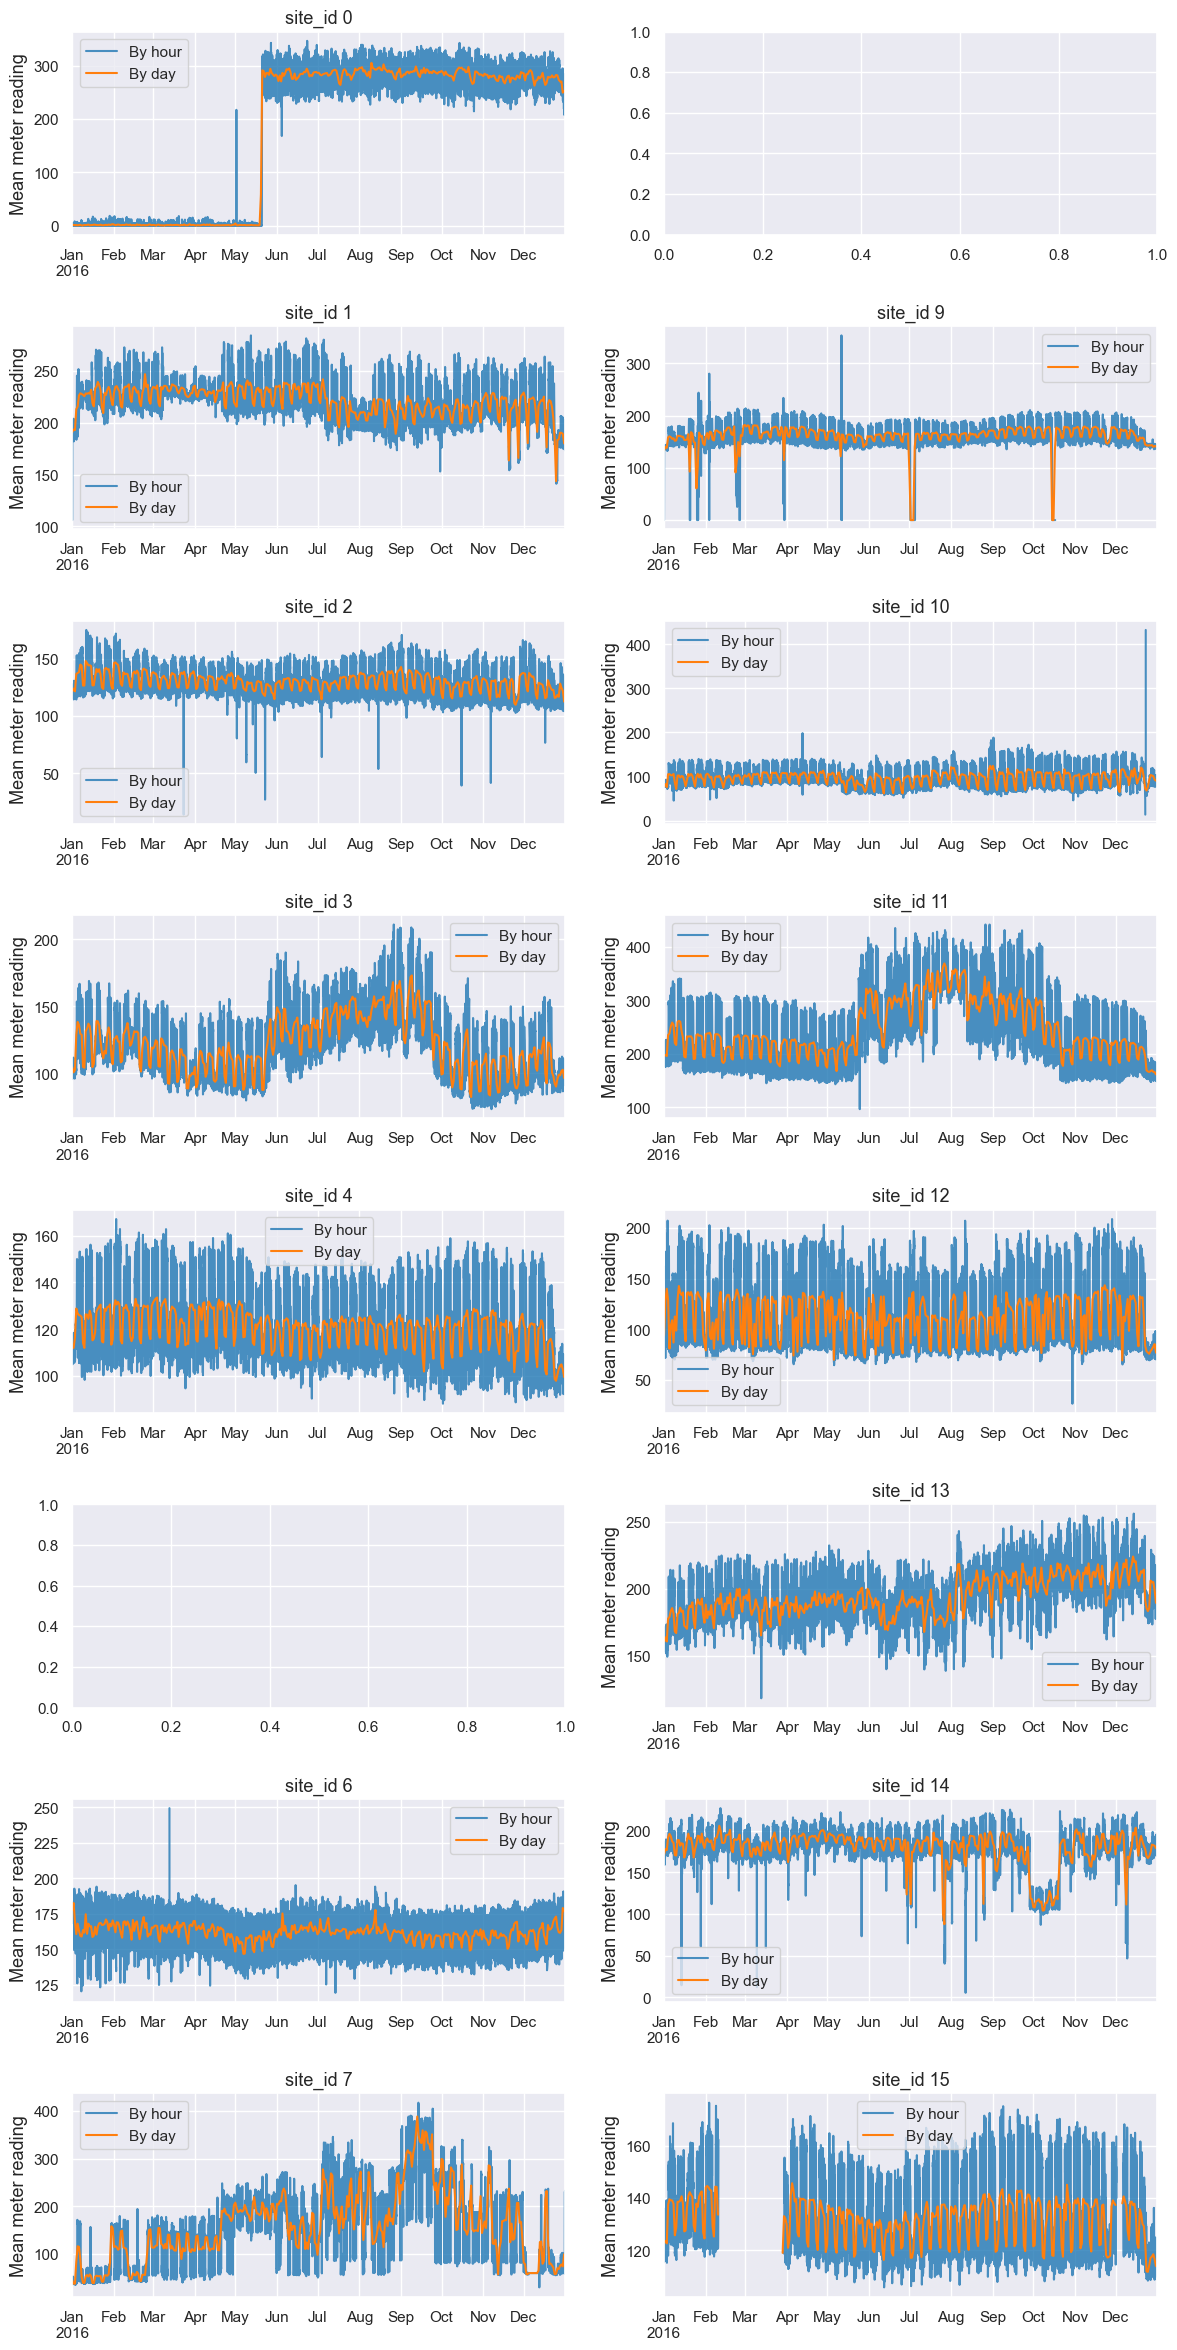

In [123]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i in range(16):
    if i == 8 or i == 5:
        continue
    train_lb[train_lb['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train_lb[train_lb['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    plt.subplots_adjust(hspace=0.45)

In [143]:
train.to_csv('../Data/train.csv') 

In [144]:
test.to_csv('../Data/test.csv') 

In [145]:
train_ub.to_csv('../Data/train_outliers.csv') 